<a href="https://colab.research.google.com/github/racoope70/exploratory_daytrading/blob/main/multi_stock_sac_inference_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Fix Potential Library Conflicts
!apt-get remove --purge -y cuda* libcuda* nvidia* || echo "No conflicting CUDA packages"
!apt-get autoremove -y
!apt-get clean

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'cuda-toolkit-12-4-config-common' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-11-0' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-11-1' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-11-7' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-11-8' for glob 'cuda*'
Note, selecting 'cuda-toolkit-12-5-config-common' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-0' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-1' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-2' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-3' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-4' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-5' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-6' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-8' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-12-9' for glob 'cuda*'
Note, selecting 'cuda-cudart-dev-13-0' fo

In [2]:
#Protocol Buffer Fix (for TensorFlow)
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [1]:
#Update Colab Environment and System Libraries
!apt-get update -y && apt-get upgrade -y


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:5 https://cli.github.com/packages stable InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,080 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Pa

In [2]:
#Install Correct Version of CUDA for Colab GPU
!apt-get update -qq && apt-get install -y \
    libcusolver11 libcusparse11 libcurand10 libcufft10 libnppig10 libnppc10 libnppial10 \
    cuda-toolkit-12-4

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libnppig10
E: Unable to locate package libnppc10
E: Unable to locate package libnppial10


In [3]:
#Set Correct CUDA Paths
import os
os.environ['CUDA_HOME'] = '/usr/local/cuda-12.4'
os.environ['PATH'] += ':/usr/local/cuda-12.4/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-12.4/lib64'


In [4]:
#Install RAPIDS and NVIDIA Dependencies
!pip install --extra-index-url=https://pypi.nvidia.com \
    cuml-cu12==25.2.0 cudf-cu12==25.2.0 cupy-cuda12x dask-cuda==25.2.0 dask-cudf-cu12==25.2.0


Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 205.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 133.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 69.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 185.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.0/405.0 MB 75.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.2/851.2 kB 166.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.5/293.5 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 161.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.7/557.7 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 134.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
#Install TensorFlow (latest GPU-compatible version)
!pip install tensorflow==2.18.0

#Install Stable Baselines3 and Trading Libraries
!pip install stable-baselines3[extra] gymnasium gym-anytrading yfinance xgboost joblib

#Install Miscellaneous Libraries
!pip install matplotlib scikit-learn pandas numba==0.61.0

#Install PyTorch with GPU Support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.3
    Uninstalling ml_dtypes-0.5.3:
      Successfully uninstalled ml_dtypes-0.5.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tens

In [2]:
#Install TensorFlow (latest GPU-compatible version)
!pip install tensorflow==2.18.0

#Immediately follow it with:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow GPU memory growth enabled")
    except RuntimeError as e:
        print(f"TensorFlow GPU memory config failed: {e}")


In [3]:
!rm -rf /content/drive

In [4]:
# ---------- Imports & Logging ----------
import os, gc, time, json, logging, warnings, re, sys
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import yfinance as yf
import pywt

def setup_logger(name="download_fe", level=logging.INFO):
    logger = logging.getLogger(name)
    logger.setLevel(level)
    # avoid duplicate handlers on re-run
    logger.handlers = []
    fmt = logging.Formatter("%(asctime)s | %(levelname)s | %(name)s | %(message)s")

    sh = logging.StreamHandler(sys.stdout)
    sh.setFormatter(fmt); sh.setLevel(level)
    logger.addHandler(sh)

    os.makedirs("./sac_parity/logs", exist_ok=True)
    fh = logging.FileHandler(os.path.join("./sac_parity/logs", f"{name}.log"))
    fh.setFormatter(fmt); fh.setLevel(level)
    logger.addHandler(fh)
    return logger

log = setup_logger("download_fe", level=logging.INFO)
warnings.filterwarnings("ignore", category=FutureWarning)
log.info("yfinance=%s | pandas=%s", getattr(yf, "__version__", "unknown"), pd.__version__)

# ---------- Paths ----------
BASE_DIR   = "./sac_parity"
DATA_DIR   = os.path.join(BASE_DIR, "data")
LOG_DIR    = os.path.join(BASE_DIR, "logs")
for d in (BASE_DIR, DATA_DIR, LOG_DIR):
    os.makedirs(d, exist_ok=True)

# Try Google Drive (Colab); else local CWD
try:
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive', force_remount=False)
    DRIVE_BASE = "/content/drive/MyDrive"
    log.info("Mounted Google Drive at /content/drive")
except Exception:
    DRIVE_BASE = os.getcwd()
    log.info("Google Drive not available; using local working directory")

RESULTS_DIR = os.path.join(DRIVE_BASE, "Results_May_2025", "results_sac_walkforward")
TRADING_DIR = os.path.join(DRIVE_BASE, "trading_data")
for d in (RESULTS_DIR, TRADING_DIR):
    os.makedirs(d, exist_ok=True)

# Primary output filenames (three mirrors)
FEATURE_CSV_RESULTS = os.path.join(RESULTS_DIR, "multi_stock_feature_engineered_dataset.csv")
FEATURE_CSV_TRADING = os.path.join(TRADING_DIR, "multi_stock_feature_engineered_dataset.csv")
FEATURE_CSV_LOCAL   = "multi_stock_feature_engineered_dataset.csv"

# Optional Parquet mirrors (local)
PARQ_FULL  = "features_full.parquet"
PARQ_TRAIN = "train.parquet"
PARQ_VAL   = "val.parquet"

# ---------- Config / Toggles ----------
USE_SENTIMENT = False   # placeholder; off by default
USE_REGIME    = True
USE_WAVELET   = True
USE_EVAL_CALLBACK = False
FORCE_RETRAIN = True

# Data params
INTERVAL     = os.getenv("INTERVAL", "1h")
PERIOD_DAYS  = int(os.getenv("PERIOD_DAYS", "720"))  # ~2 years by default

# If you want to prep for a 1y train + 1y test split later, ensure ~744 days
TRAIN_DAYS_TARGET = 365
TEST_DAYS_TARGET  = 365
BUFFER_DAYS       = 14
MIN_PERIOD_FOR_TRAINER = TRAIN_DAYS_TARGET + TEST_DAYS_TARGET + BUFFER_DAYS  # ~744

# --- Yahoo intraday maximum window helper ---
def _max_days_for_interval(interval: str) -> int:
    """Yahoo intraday windows are restricted; daily/weekly can go further."""
    intraday_caps = {
        "1m": 30, "2m": 60, "5m": 60, "15m": 60, "30m": 60,
        "60m": 730, "90m": 60, "1h": 730
    }
    return intraday_caps.get(interval.lower(), 3650)


TEST_MODE   = os.getenv("TEST_MODE", "1").lower() not in ("0", "false", "no", "")
PREP_FOR_SAC = os.getenv("PREP_FOR_SAC", "1").lower() not in ("0", "false", "no", "")
if PREP_FOR_SAC and PERIOD_DAYS < MIN_PERIOD_FOR_TRAINER:
    log.info("Bumping PERIOD_DAYS %d → %d to support ~1y train / ~1y test", PERIOD_DAYS, MIN_PERIOD_FOR_TRAINER)
    PERIOD_DAYS = MIN_PERIOD_FOR_TRAINER

# --- Cap for Yahoo intraday data limits (avoid >730 days error) ---
_cap = _max_days_for_interval(INTERVAL)
if PERIOD_DAYS > _cap:
    log.warning("PERIOD_DAYS=%d exceeds Yahoo limit (%d) for interval='%s'; capping.",
                PERIOD_DAYS, _cap, INTERVAL)
    PERIOD_DAYS = _cap

# ---------- Universe ----------
TICKERS_ALL = [
    'AAPL','TSLA','MSFT','GOOGL','AMZN','NVDA','META','BRK-B','JPM','JNJ',
    'XOM','V','PG','UNH','MA','HD','LLY','MRK','PEP','KO',
    'BAC','ABBV','AVGO','PFE','COST','CSCO','TMO','ABT','ACN','WMT',
    'MCD','ADBE','DHR','CRM','NKE','INTC','QCOM','NEE','AMD','TXN',
    'AMGN','UPS','LIN','PM','UNP','BMY','LOW','RTX','CVX','IBM',
    'GE','SBUX','ORCL'
]
DEFAULT_TEST_TICKERS = ['AAPL','NVDA','MSFT']
RUN_SYMBOLS_ENV  = [s.strip().upper() for s in os.getenv("RUN_SYMBOLS", "").split(",") if s.strip()]
TEST_TICKERS_ENV = [s.strip().upper() for s in os.getenv("TEST_TICKERS", "").split(",") if s.strip()]

if RUN_SYMBOLS_ENV:
    SYMBOLS = RUN_SYMBOLS_ENV
    log.info("RUN_SYMBOLS override → %s", SYMBOLS)
elif TEST_MODE:
    SYMBOLS = TEST_TICKERS_ENV if TEST_TICKERS_ENV else DEFAULT_TEST_TICKERS
    log.info("TEST_MODE=on → symbols=%s | period_days=%d", SYMBOLS, PERIOD_DAYS)
else:
    SYMBOLS = TICKERS_ALL
    log.info("TEST_MODE=off → %d symbols | period_days=%d", len(SYMBOLS), PERIOD_DAYS)

# ---------- Helpers: atomic save + verification ----------
def _ensure_dir(path: str):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)

def save_csv_atomically(df: pd.DataFrame, dest_path: str, max_wait_s: float = 3.0):
    """Write via dest.tmp then os.replace(); verify non-zero size (Colab/Drive-safe)."""
    _ensure_dir(dest_path)
    tmp_path = dest_path + ".tmp"
    df.to_csv(tmp_path, index=False)
    os.replace(tmp_path, dest_path)
    t0 = time.time()
    while (not os.path.exists(dest_path) or os.path.getsize(dest_path) == 0) and (time.time() - t0 < max_wait_s):
        time.sleep(0.2)
    assert os.path.exists(dest_path) and os.path.getsize(dest_path) > 0, f"Save failed for {dest_path}"
    return dest_path

def _verify_csv_ok(p: str) -> bool:
    try:
        if not (os.path.exists(p) and os.path.getsize(p) > 0):
            return False
        _ = pd.read_csv(p, nrows=2)
        log.info("Verified dataset CSV: %s (%s bytes)", p, f"{os.path.getsize(p):,}")
        return True
    except Exception as e:
        log.warning("Dataset candidate failed verification (%s): %s", p, e)
        return False

def _log_artifact(p: str):
    try:
        ok = os.path.exists(p); sz = os.path.getsize(p) if ok else 0
        tm = time.ctime(os.path.getmtime(p)) if ok else "-"
        head = pd.read_csv(p, nrows=2)
        log.info("Artifact OK: %s | size=%s | mtime=%s | cols=%s",
                 p, f"{sz:,}", tm, list(head.columns)[:8])
        log.info("Head preview:\n%s", head.to_string(index=False))
    except Exception as e:
        log.warning("Artifact check failed for %s: %s", p, e)

# ---------- Helpers: schema / normalize ----------
def _force_datetime_column(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure tz-naive Datetime column exists; dedupe/sort."""
    if isinstance(df.index, pd.DatetimeIndex):
        try:
            if df.index.tz is not None:
                df.index = df.index.tz_convert(None)
        except Exception:
            try:
                df.index = df.index.tz_localize(None)
            except Exception:
                pass
        df.index.name = 'Datetime'
        df = df.reset_index()
    else:
        df = df.reset_index()
        first = df.columns[0]
        if np.issubdtype(df[first].dtype, np.datetime64):
            df = df.rename(columns={first: 'Datetime'})
        elif 'Date' in df.columns:
            df['Datetime'] = pd.to_datetime(df['Date'])
        elif 'Datetime' not in df.columns:
            df['Datetime'] = pd.to_datetime(df[first], errors='coerce')

    if 'Datetime' not in df.columns:
        raise KeyError("Failed to construct 'Datetime' from data.")

    df['Datetime'] = pd.to_datetime(df['Datetime'])
    return df.drop_duplicates(subset=['Datetime']).sort_values('Datetime').reset_index(drop=True)

def _normalize_ohlcv(df_in: pd.DataFrame, ticker: str) -> pd.DataFrame:
    """Flatten MultiIndex; strip ticker tokens; map to canonical OHLCV names."""
    df = df_in.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [" ".join([str(p) for p in col if p]) for col in df.columns]
    df.columns = [re.sub(r"\s+", " ", str(c)).strip() for c in df.columns]

    tkr = ticker.upper().replace("-", "[- ]?")
    cleaned = {}
    for c in df.columns:
        cu = c.upper()
        cu = re.sub(rf"^(?:{tkr})[\s/_-]+", "", cu)
        cu = re.sub(rf"[\s/_-]+(?:{tkr})$", "", cu)
        cleaned[c] = cu.title()
    if any(cleaned[c] != c for c in df.columns):
        df = df.rename(columns=cleaned)

    cols_ci = {c.lower(): c for c in df.columns}
    wants = {
        "Open":      ["open"],
        "High":      ["high"],
        "Low":       ["low"],
        "Close":     ["close", "last", "close*"],
        "Adj Close": ["adj close","adj_close","adjclose","adjusted close"],
        "Volume":    ["volume","vol"]
    }
    rename_map = {}
    for desired, alts in wants.items():
        if desired.lower() in cols_ci:
            rename_map[cols_ci[desired.lower()]] = desired
        else:
            for a in alts:
                if a in cols_ci:
                    rename_map[cols_ci[a]] = desired
                    break
    if rename_map:
        df = df.rename(columns=rename_map)
    return df

# ---------- Downloader (with history() fallback & retries) ----------
def download_stock_data(ticker, interval="1h", period_days=720, max_retries=5, sleep_base=3):
    """
    Robust yfinance intraday downloader.
    Guarantees: Open, High, Low, Close, Volume (+Adj Close), Datetime, Symbol.
    """
    period_days = int(period_days)
    period_str = f"{period_days}d"

    def _post(df: pd.DataFrame) -> pd.DataFrame:
        df = _normalize_ohlcv(df, ticker)
        df = _force_datetime_column(df)
        needed = {'Open', 'High', 'Low', 'Close', 'Volume'}
        missing = needed - set(df.columns)
        if missing:
            raise ValueError(f"Missing OHLCV columns after normalize: {missing}")
        if 'Adj Close' not in df.columns:
            df['Adj Close'] = df['Close']
        return df

    for attempt in range(1, max_retries + 1):
        try:
            log.info(f"[{ticker}] Attempt {attempt}: download(period={period_str}, interval={interval})")
            df = yf.download(
                tickers=ticker,
                period=period_str,
                interval=interval,
                progress=False,
                auto_adjust=False,
                group_by='column',
                threads=False,
                prepost=False,
                repair=True
            )
            if df is None or df.empty:
                raise ValueError("Empty data from download()")

            df = _post(df)
            df['Symbol'] = ticker
            log.info(f"[{ticker}] rows={len(df)} {df['Datetime'].min()} → {df['Datetime'].max()}")
            return df

        except Exception as e1:
            # --- Yahoo 730-day clamp logic (self-heal) ---
            msg = str(e1)
            too_long = ("must be within the last 730 days" in msg.lower()) or ("no price data found" in msg.lower())
            if too_long:
                clamp_days = _max_days_for_interval(interval)
                if period_days > clamp_days:
                    log.warning("[%s] Yahoo limit hit (%s). Retrying with period_days=%d.", ticker, e1, clamp_days)
                    period_days = clamp_days
                    period_str = f"{period_days}d"
                    try:
                        df = yf.download(
                            tickers=ticker, period=period_str, interval=interval,
                            progress=False, auto_adjust=False, group_by='column',
                            threads=False, prepost=False, repair=True
                        )
                        if df is not None and not df.empty:
                            df = _post(df)
                            df['Symbol'] = ticker
                            log.info(f"[{ticker}] rows={len(df)} {df['Datetime'].min()} → {df['Datetime'].max()} (clamped)")
                            return df
                    except Exception as e1b:
                        log.warning("[%s] clamp retry failed (%s); will try history() fallback.", ticker, e1b)

            # --- history() fallback with backoff ---
            log.warning(f"[{ticker}] download() error: {e1} | trying Ticker().history()")
            try:
                hist = yf.Ticker(ticker).history(
                    period=period_str,
                    interval=interval,
                    auto_adjust=False,
                    actions=False
                )
                if hist is None or hist.empty:
                    raise ValueError("Empty data from history()")

                df = _post(hist)
                df['Symbol'] = ticker
                log.info(f"[{ticker}] (fallback) rows={len(df)} {df['Datetime'].min()} → {df['Datetime'].max()}")
                return df

            except Exception as e2:
                wait = sleep_base * attempt
                log.warning(f"[{ticker}] history() error: {e2} | retrying in {wait}s")
                time.sleep(wait)

    log.error(f"[{ticker}] Failed after {max_retries} attempts.")
    return None


# ---------- Feature Engineering ----------
def denoise_wavelet(series, wavelet='db1', level=2):
    s = pd.Series(series).astype(float).ffill().bfill().to_numpy()
    try:
        coeffs = pywt.wavedec(s, wavelet, mode='symmetric', level=level)
        # Hard smoothing: zero high-frequency detail
        for i in range(1, len(coeffs)):
            coeffs[i] = np.zeros_like(coeffs[i])
        rec = pywt.waverec(coeffs, wavelet, mode='symmetric')
        return pd.Series(rec[:len(s)], index=series.index)
    except Exception as e:
        log.warning(f"Wavelet denoise failed ({e}); returning raw series.")
        return pd.Series(s, index=series.index)

def add_regime(df: pd.DataFrame) -> pd.DataFrame:
    df['Vol20'] = df['Close'].pct_change().rolling(20).std()
    df['Ret20'] = df['Close'].pct_change(20)
    vol_hi   = (df['Vol20'] > df['Vol20'].median()).astype(int)
    trend_hi = (df['Ret20'].abs() > df['Ret20'].abs().median()).astype(int)
    df['Regime4'] = vol_hi * 2 + trend_hi  # 0..3
    return df

def compute_enhanced_features(df: pd.DataFrame) -> tuple[pd.DataFrame, list]:
    """
    Returns (feature_df, FEATURES). Input must contain:
      Datetime, Symbol, Open, High, Low, Close, Volume.
    """
    df = df.copy()
    req = {"Open", "High", "Low", "Close", "Volume"}
    assert req.issubset(df.columns), f"OHLCV columns missing: {req - set(df.columns)}"

    close = df["Close"].astype("float64")
    high  = df["High"].astype("float64")
    low   = df["Low"].astype("float64")
    open_ = df["Open"].astype("float64")
    vol   = (df["Volume"].astype("float64") + 1.0)

    # Returns & lags
    df["ret_1"]     = close.pct_change(1)
    df["ret_3"]     = close.pct_change(3)
    df["ret_5"]     = close.pct_change(5)
    df["ret_10"]    = close.pct_change(10)
    df["logret_1"]  = np.log(close).diff(1)

    # MAs & volatility
    df["ma_5"]      = close.rolling(5).mean()
    df["ma_10"]     = close.rolling(10).mean()
    df["ma_20"]     = close.rolling(20).mean()
    df["ema_10"]    = close.ewm(span=10, adjust=False).mean()
    df["ema_20"]    = close.ewm(span=20, adjust=False).mean()
    df["std_10"]    = close.rolling(10).std()
    df["std_20"]    = close.rolling(20).std()
    df["ema10_ratio"] = df["ema_10"] / close - 1.0
    df["ema20_ratio"] = df["ema_20"] / close - 1.0
    df["z_close_20"] = (close - df["ma_20"]) / df["std_20"].replace(0, np.nan)

    # RSI(14)
    delta      = close.diff()
    up         = delta.clip(lower=0.0)
    down       = -delta.clip(upper=0.0)
    roll_up    = up.ewm(alpha=1/14, adjust=False).mean()
    roll_down  = down.ewm(alpha=1/14, adjust=False).mean()
    rs         = roll_up / roll_down.replace(0, np.nan)
    df["rsi_14"] = 100 - (100 / (1 + rs))

    # Stochastic(14,3)
    ll14       = low.rolling(14).min()
    hh14       = high.rolling(14).max()
    den_14     = (hh14 - ll14).replace(0, np.nan)
    df["stoch_k"] = 100 * (close - ll14) / den_14
    df["stoch_d"] = df["stoch_k"].rolling(3).mean()

    # MACD (12,26,9)
    ema12         = close.ewm(span=12, adjust=False).mean()
    ema26         = close.ewm(span=26, adjust=False).mean()
    macd          = ema12 - ema26
    macd_sig      = macd.ewm(span=9, adjust=False).mean()
    df["macd"]        = macd
    df["macd_signal"] = macd_sig
    df["macd_hist"]   = macd - macd_sig

    # Bollinger (20,2)
    bb_mid      = df["ma_20"]
    bb_std      = df["std_20"]
    bb_up       = bb_mid + 2 * bb_std
    bb_lo       = bb_mid - 2 * bb_std
    band_width  = (bb_up - bb_lo)
    df["bb_perc_b"]    = (close - bb_lo) / band_width.replace(0, np.nan)
    df["bb_bandwidth"] = band_width / bb_mid.replace(0, np.nan)

    # ATR(14)
    prev_close  = close.shift(1)
    tr = np.maximum(high - low,
                    np.maximum((high - prev_close).abs(), (low - prev_close).abs()))
    df["atr_14"] = tr.rolling(14).mean()

    # Volume features
    df["vol_ma_20"]    = vol.rolling(20).mean()
    df["vol_std_20"]   = vol.rolling(20).std()
    df["vol_z_20"]     = (vol - df["vol_ma_20"]) / df["vol_std_20"].replace(0, np.nan)
    df["vol_change_1"] = vol.pct_change(1)

    # Spreads & crosses
    df["hl_spread"] = (high - low) / close.replace(0, np.nan)
    df["oc_spread"] = (close - open_) / open_.replace(0, np.nan)
    df["ema10_gt_ema20"] = (df["ema_10"] > df["ema_20"]).astype("float32")

    # Optional extras
    if USE_WAVELET:
        df["denoised_close"] = denoise_wavelet(pd.Series(close, index=df.index))
    if USE_REGIME:
        df = add_regime(df)  # adds 'Regime4'

    # Clean up
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0.0, inplace=True)

    FEATURES = [
        "ret_1","ret_3","ret_5","ret_10","logret_1",
        "ma_5","ma_10","ma_20","ema_10","ema_20","ema10_ratio","ema20_ratio",
        "std_10","std_20","z_close_20",
        "rsi_14","stoch_k","stoch_d",
        "macd","macd_signal","macd_hist",
        "bb_perc_b","bb_bandwidth",
        "atr_14",
        "vol_ma_20","vol_std_20","vol_z_20","vol_change_1",
        "hl_spread","oc_spread","ema10_gt_ema20",
    ]
    df[FEATURES] = df[FEATURES].astype("float32")
    return df, FEATURES

# ---------- Orchestrator ----------
VAL_FRACTION = float(os.getenv("VAL_FRACTION", "0.20"))  # only for optional local train/val files
CANDIDATE_CSVS = [FEATURE_CSV_LOCAL, FEATURE_CSV_RESULTS, FEATURE_CSV_TRADING]

def build_features() -> pd.DataFrame:
    # ---- PPO-style: re-use any healthy dataset across locations ----
    for cand in CANDIDATE_CSVS:
        if _verify_csv_ok(cand):
            d = pd.read_csv(cand)
            d['Datetime'] = pd.to_datetime(d['Datetime'], utc=True)  # keep UTC in memory
            log.info("Using existing features CSV: %s | rows=%d cols=%d", cand, len(d), d.shape[1])
            return d

    all_dfs = []
    for i, ticker in enumerate(SYMBOLS, 1):
        log.info(f"[{i}/{len(SYMBOLS)}] {ticker} — downloading")
        raw = download_stock_data(ticker, interval=INTERVAL, period_days=PERIOD_DAYS)
        if raw is None or raw.empty:
            log.warning(f"[{ticker}] no data; skipping.")
            continue
        try:
            feats, _ = compute_enhanced_features(raw)
            if feats is not None and not feats.empty:
                outp = os.path.join(DATA_DIR, f"{ticker}.parquet")
                feats.to_parquet(outp, index=False)
                log.info(f"[{ticker}] features={len(feats)} rows → {outp}")
                all_dfs.append(feats)
            else:
                log.warning(f"[{ticker}] empty features; skipped.")
        except Exception as e:
            log.error(f"[{ticker}] FE failed: {e}")
        finally:
            del raw
            try: del feats
            except: pass
            gc.collect()
            time.sleep(0.2)

    if not all_dfs:
        raise RuntimeError("No usable data found for any ticker.")

    full = pd.concat(all_dfs, ignore_index=True)

    # ---- Keep UTC in storage; only convert a view to NY for RTH mask ----
    full['Datetime'] = pd.to_datetime(full['Datetime'], utc=True)  # tz-aware UTC for storage
    dt_ny = full['Datetime'].dt.tz_convert('America/New_York')
    rth_mask = (
        (dt_ny.dt.weekday < 5) &
        (dt_ny.dt.time >= pd.to_datetime("09:30").time()) &
        (dt_ny.dt.time <  pd.to_datetime("16:00").time())
    )
    full = full[rth_mask].reset_index(drop=True)

    # ---- Save atomically: local + both Drive locations ----
    save_csv_atomically(full, FEATURE_CSV_LOCAL)
    save_csv_atomically(full, FEATURE_CSV_RESULTS)
    save_csv_atomically(full, FEATURE_CSV_TRADING)

    # Parquet mirror (local)
    full.to_parquet(PARQ_FULL, index=False)

    # Diagnostics: existence + size + small preview
    for p in (FEATURE_CSV_LOCAL, FEATURE_CSV_RESULTS, FEATURE_CSV_TRADING):
        _log_artifact(p)

    log.info("Saved combined CSV (rows=%d) →\n- %s\n- %s\n- %s",
             len(full), FEATURE_CSV_LOCAL, FEATURE_CSV_RESULTS, FEATURE_CSV_TRADING)
    return full

# ---------- Optional: utility used by training scripts ----------
def find_or_build_dataset():
    """Try local/Drive mirrors; if none, build and save to all mirrors."""
    for cand in CANDIDATE_CSVS:
        if _verify_csv_ok(cand):
            df = pd.read_csv(cand)
            df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
            return cand, df
    df = build_features()
    save_csv_atomically(df, FEATURE_CSV_LOCAL)
    save_csv_atomically(df, FEATURE_CSV_RESULTS)
    save_csv_atomically(df, FEATURE_CSV_TRADING)
    return FEATURE_CSV_LOCAL, df

# ---------- Run end-to-end ----------
if __name__ == "__main__":
    df_full = build_features()

    # (Optional) Create quick time-based train/val splits locally for inspection
    try:
        df_full = df_full.sort_values('Datetime').reset_index(drop=True)
        cutoff_idx = int((1.0 - VAL_FRACTION) * len(df_full))
        cutoff_idx = min(max(1, cutoff_idx), len(df_full) - 1)  # guardrails
        cutoff_time = df_full.loc[cutoff_idx, 'Datetime']
        train_df = df_full[df_full['Datetime'] <  cutoff_time].reset_index(drop=True)
        val_df   = df_full[df_full['Datetime'] >= cutoff_time].reset_index(drop=True)

        # Atomic saves everywhere (local + Drive mirror for convenience)
        save_csv_atomically(df_full,  FEATURE_CSV_LOCAL)   # ensure latest combined locally
        save_csv_atomically(train_df, "train.csv")
        save_csv_atomically(val_df,   "val.csv")

        # Drive mirror of splits
        save_csv_atomically(train_df, os.path.join(TRADING_DIR, "train.csv"))
        save_csv_atomically(val_df,   os.path.join(TRADING_DIR, "val.csv"))

        # Parquet mirrors
        train_df.to_parquet(PARQ_TRAIN, index=False)
        val_df.to_parquet(PARQ_VAL, index=False)

        log.info("Time split cutoff @ %s", cutoff_time)
        log.info("Train: %s, Val: %s", train_df.shape, val_df.shape)

        for p in ("train.csv", "val.csv", PARQ_TRAIN, PARQ_VAL):
            exists = os.path.exists(p)
            sz = os.path.getsize(p) if exists else 0
            log.info("Saved split artifact: exists=%s | size=%s | path=%s", exists, sz, p)

        # Light summary
        try:
            sym_counts = df_full['Symbol'].value_counts()
            log.info("Symbols saved (top 10):\n%s", sym_counts.head(10).to_string())
            log.info("Datetime range: %s → %s", df_full['Datetime'].min(), df_full['Datetime'].max())
        except Exception:
            pass

        # Log artifacts
        for p in (FEATURE_CSV_LOCAL,
                  os.path.join(TRADING_DIR, "train.csv"),
                  os.path.join(TRADING_DIR, "val.csv")):
            _log_artifact(p)

        # Cleanup refs
        del train_df, val_df
    except Exception as e:
        log.warning("Train/Val split skipped: %s", e)

    gc.collect()
    log.info("✅ Download + Feature Build complete.")

2025-10-14 14:03:14,529 | INFO | download_fe | yfinance=0.2.66 | pandas=2.2.2


INFO:download_fe:yfinance=0.2.66 | pandas=2.2.2


2025-10-14 14:05:15,980 | INFO | download_fe | Google Drive not available; using local working directory


INFO:download_fe:Google Drive not available; using local working directory


2025-10-14 14:05:15,990 | INFO | download_fe | Bumping PERIOD_DAYS 720 → 744 to support ~1y train / ~1y test


INFO:download_fe:Bumping PERIOD_DAYS 720 → 744 to support ~1y train / ~1y test


2025-10-14 14:05:15,996 | WARNING | download_fe | PERIOD_DAYS=744 exceeds Yahoo limit (730) for interval='1h'; capping.


2025-10-14 14:05:16,001 | INFO | download_fe | TEST_MODE=on → symbols=['AAPL', 'NVDA', 'MSFT'] | period_days=730


INFO:download_fe:TEST_MODE=on → symbols=['AAPL', 'NVDA', 'MSFT'] | period_days=730


2025-10-14 14:05:16,022 | INFO | download_fe | [1/3] AAPL — downloading


INFO:download_fe:[1/3] AAPL — downloading


2025-10-14 14:05:16,027 | INFO | download_fe | [AAPL] Attempt 1: download(period=730d, interval=1h)


INFO:download_fe:[AAPL] Attempt 1: download(period=730d, interval=1h)


2025-10-14 14:05:17,255 | INFO | download_fe | [AAPL] rows=5076 2022-11-15 14:30:00 → 2025-10-14 13:30:00


INFO:download_fe:[AAPL] rows=5076 2022-11-15 14:30:00 → 2025-10-14 13:30:00


2025-10-14 14:05:17,456 | INFO | download_fe | [AAPL] features=5076 rows → ./sac_parity/data/AAPL.parquet


INFO:download_fe:[AAPL] features=5076 rows → ./sac_parity/data/AAPL.parquet


2025-10-14 14:05:17,933 | INFO | download_fe | [2/3] NVDA — downloading


INFO:download_fe:[2/3] NVDA — downloading


2025-10-14 14:05:17,935 | INFO | download_fe | [NVDA] Attempt 1: download(period=730d, interval=1h)


INFO:download_fe:[NVDA] Attempt 1: download(period=730d, interval=1h)


2025-10-14 14:05:19,630 | INFO | download_fe | [NVDA] rows=5076 2022-11-15 14:30:00 → 2025-10-14 13:30:00


INFO:download_fe:[NVDA] rows=5076 2022-11-15 14:30:00 → 2025-10-14 13:30:00


2025-10-14 14:05:19,707 | INFO | download_fe | [NVDA] features=5076 rows → ./sac_parity/data/NVDA.parquet


INFO:download_fe:[NVDA] features=5076 rows → ./sac_parity/data/NVDA.parquet


2025-10-14 14:05:20,184 | INFO | download_fe | [3/3] MSFT — downloading


INFO:download_fe:[3/3] MSFT — downloading


2025-10-14 14:05:20,186 | INFO | download_fe | [MSFT] Attempt 1: download(period=730d, interval=1h)


INFO:download_fe:[MSFT] Attempt 1: download(period=730d, interval=1h)


2025-10-14 14:05:20,881 | INFO | download_fe | [MSFT] rows=5076 2022-11-15 14:30:00 → 2025-10-14 13:30:00


INFO:download_fe:[MSFT] rows=5076 2022-11-15 14:30:00 → 2025-10-14 13:30:00


2025-10-14 14:05:20,954 | INFO | download_fe | [MSFT] features=5076 rows → ./sac_parity/data/MSFT.parquet


INFO:download_fe:[MSFT] features=5076 rows → ./sac_parity/data/MSFT.parquet


2025-10-14 14:05:24,305 | INFO | download_fe | Artifact OK: multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:22 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


INFO:download_fe:Artifact OK: multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:22 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


2025-10-14 14:05:24,330 | INFO | download_fe | Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol     ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20    ema_10    ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d      macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL  0.000000    0.0    0.0     0.0  0.000000   0.0    0.0    0.0 153.17000 153.17000     0.0     0.0     0.000000     0.000000         0.0     0.0      0.0      0.0  0.000000     0.000000   0.000000        0.0           0.0     0.0        0.0         0.0       0.0      0.000000   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 15:30:

INFO:download_fe:Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol     ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20    ema_10    ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d      macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL  0.000000    0.0    0.0     0.0  0.000000   0.0    0.0    0.0 153.17000 153.17000     0.0     0.0     0.000000     0.000000         0.0     0.0      0.0      0.0  0.000000     0.000000   0.000000        0.0           0.0     0.0        0.0         0.0       0.0      0.000000   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 15:30:00+00:00 150.039532 152.154999

2025-10-14 14:05:24,340 | INFO | download_fe | Artifact OK: /content/Results_May_2025/results_sac_walkforward/multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:23 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


INFO:download_fe:Artifact OK: /content/Results_May_2025/results_sac_walkforward/multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:23 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


2025-10-14 14:05:24,366 | INFO | download_fe | Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol     ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20    ema_10    ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d      macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL  0.000000    0.0    0.0     0.0  0.000000   0.0    0.0    0.0 153.17000 153.17000     0.0     0.0     0.000000     0.000000         0.0     0.0      0.0      0.0  0.000000     0.000000   0.000000        0.0           0.0     0.0        0.0         0.0       0.0      0.000000   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 15:30:

INFO:download_fe:Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol     ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20    ema_10    ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d      macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL  0.000000    0.0    0.0     0.0  0.000000   0.0    0.0    0.0 153.17000 153.17000     0.0     0.0     0.000000     0.000000         0.0     0.0      0.0      0.0  0.000000     0.000000   0.000000        0.0           0.0     0.0        0.0         0.0       0.0      0.000000   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 15:30:00+00:00 150.039532 152.154999

2025-10-14 14:05:24,374 | INFO | download_fe | Artifact OK: /content/trading_data/multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:24 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


INFO:download_fe:Artifact OK: /content/trading_data/multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:24 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


2025-10-14 14:05:24,389 | INFO | download_fe | Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol     ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20    ema_10    ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d      macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL  0.000000    0.0    0.0     0.0  0.000000   0.0    0.0    0.0 153.17000 153.17000     0.0     0.0     0.000000     0.000000         0.0     0.0      0.0      0.0  0.000000     0.000000   0.000000        0.0           0.0     0.0        0.0         0.0       0.0      0.000000   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 15:30:

INFO:download_fe:Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol     ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20    ema_10    ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d      macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL  0.000000    0.0    0.0     0.0  0.000000   0.0    0.0    0.0 153.17000 153.17000     0.0     0.0     0.000000     0.000000         0.0     0.0      0.0      0.0  0.000000     0.000000   0.000000        0.0           0.0     0.0        0.0         0.0       0.0      0.000000   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 15:30:00+00:00 150.039532 152.154999

2025-10-14 14:05:24,391 | INFO | download_fe | Saved combined CSV (rows=15228) →
- multi_stock_feature_engineered_dataset.csv
- /content/Results_May_2025/results_sac_walkforward/multi_stock_feature_engineered_dataset.csv
- /content/trading_data/multi_stock_feature_engineered_dataset.csv


INFO:download_fe:Saved combined CSV (rows=15228) →
- multi_stock_feature_engineered_dataset.csv
- /content/Results_May_2025/results_sac_walkforward/multi_stock_feature_engineered_dataset.csv
- /content/trading_data/multi_stock_feature_engineered_dataset.csv


2025-10-14 14:05:27,818 | INFO | download_fe | Time split cutoff @ 2025-03-17 16:30:00+00:00


INFO:download_fe:Time split cutoff @ 2025-03-17 16:30:00+00:00


2025-10-14 14:05:27,820 | INFO | download_fe | Train: (12180, 44), Val: (3048, 44)


INFO:download_fe:Train: (12180, 44), Val: (3048, 44)


2025-10-14 14:05:27,821 | INFO | download_fe | Saved split artifact: exists=True | size=6469645 | path=train.csv


INFO:download_fe:Saved split artifact: exists=True | size=6469645 | path=train.csv


2025-10-14 14:05:27,822 | INFO | download_fe | Saved split artifact: exists=True | size=1620541 | path=val.csv


INFO:download_fe:Saved split artifact: exists=True | size=1620541 | path=val.csv


2025-10-14 14:05:27,823 | INFO | download_fe | Saved split artifact: exists=True | size=2988869 | path=train.parquet


INFO:download_fe:Saved split artifact: exists=True | size=2988869 | path=train.parquet


2025-10-14 14:05:27,825 | INFO | download_fe | Saved split artifact: exists=True | size=741953 | path=val.parquet


INFO:download_fe:Saved split artifact: exists=True | size=741953 | path=val.parquet


2025-10-14 14:05:27,829 | INFO | download_fe | Symbols saved (top 10):
Symbol
AAPL    5076
NVDA    5076
MSFT    5076


INFO:download_fe:Symbols saved (top 10):
Symbol
AAPL    5076
NVDA    5076
MSFT    5076


2025-10-14 14:05:27,832 | INFO | download_fe | Datetime range: 2022-11-15 14:30:00+00:00 → 2025-10-14 13:30:00+00:00


INFO:download_fe:Datetime range: 2022-11-15 14:30:00+00:00 → 2025-10-14 13:30:00+00:00


2025-10-14 14:05:27,838 | INFO | download_fe | Artifact OK: multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:25 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


INFO:download_fe:Artifact OK: multi_stock_feature_engineered_dataset.csv | size=8,089,816 | mtime=Tue Oct 14 14:05:25 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


2025-10-14 14:05:27,857 | INFO | download_fe | Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol  ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20  ema_10  ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d  macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL    0.0    0.0    0.0     0.0       0.0   0.0    0.0    0.0 153.170 153.170     0.0     0.0          0.0          0.0         0.0     0.0      0.0      0.0   0.0          0.0        0.0        0.0           0.0     0.0        0.0         0.0       0.0           0.0   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 14:30:00+00:00  16.902688  1

INFO:download_fe:Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol  ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20  ema_10  ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d  macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL    0.0    0.0    0.0     0.0       0.0   0.0    0.0    0.0 153.170 153.170     0.0     0.0          0.0          0.0         0.0     0.0      0.0      0.0   0.0          0.0        0.0        0.0           0.0     0.0        0.0         0.0       0.0           0.0   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 14:30:00+00:00  16.902688  16.923000  16.997999  16.670000

2025-10-14 14:05:27,864 | INFO | download_fe | Artifact OK: /content/trading_data/train.csv | size=6,469,645 | mtime=Tue Oct 14 14:05:27 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


INFO:download_fe:Artifact OK: /content/trading_data/train.csv | size=6,469,645 | mtime=Tue Oct 14 14:05:27 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


2025-10-14 14:05:27,883 | INFO | download_fe | Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol  ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20  ema_10  ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d  macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL    0.0    0.0    0.0     0.0       0.0   0.0    0.0    0.0 153.170 153.170     0.0     0.0          0.0          0.0         0.0     0.0      0.0      0.0   0.0          0.0        0.0        0.0           0.0     0.0        0.0         0.0       0.0           0.0   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 14:30:00+00:00  16.902688  1

INFO:download_fe:Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol  ret_1  ret_3  ret_5  ret_10  logret_1  ma_5  ma_10  ma_20  ema_10  ema_20  std_10  std_20  ema10_ratio  ema20_ratio  z_close_20  rsi_14  stoch_k  stoch_d  macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth  atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close  Vol20  Ret20  Regime4
2022-11-15 14:30:00+00:00 151.040419 153.169998 153.589996 151.679993 152.214996       True 21958202   AAPL    0.0    0.0    0.0     0.0       0.0   0.0    0.0    0.0 153.170 153.170     0.0     0.0          0.0          0.0         0.0     0.0      0.0      0.0   0.0          0.0        0.0        0.0           0.0     0.0        0.0         0.0       0.0           0.0   0.012470   0.006274             0.0      151.791248    0.0    0.0        0
2022-11-15 14:30:00+00:00  16.902688  16.923000  16.997999  16.670000

2025-10-14 14:05:27,889 | INFO | download_fe | Artifact OK: /content/trading_data/val.csv | size=1,620,541 | mtime=Tue Oct 14 14:05:27 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


INFO:download_fe:Artifact OK: /content/trading_data/val.csv | size=1,620,541 | mtime=Tue Oct 14 14:05:27 2025 | cols=['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']


2025-10-14 14:05:27,907 | INFO | download_fe | Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol    ret_1     ret_3     ret_5    ret_10  logret_1       ma_5   ma_10     ma_20    ema_10   ema_20   std_10   std_20  ema10_ratio  ema20_ratio  z_close_20    rsi_14   stoch_k  stoch_d     macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth   atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close    Vol20    Ret20  Regime4
2025-03-17 16:30:00+00:00 386.961904 388.309998 388.599915 386.917999 387.000000       True  1207593   MSFT 0.003489 -0.002146  0.000567  0.017757  0.003483 387.931000 387.391 383.99960 386.68228 385.3296 1.177787 3.794697    -0.004192    -0.007675    1.135902 59.229355 84.443275 76.92684 1.210875     0.513046   0.697829   0.783975      0.039528 2.569561  2189380.5    847302.5 -1.158720      0.011233   0.004331   0.003385             1.0      390.015

INFO:download_fe:Head preview:
                 Datetime  Adj Close      Close       High        Low       Open  Repaired?   Volume Symbol    ret_1     ret_3     ret_5    ret_10  logret_1       ma_5   ma_10     ma_20    ema_10   ema_20   std_10   std_20  ema10_ratio  ema20_ratio  z_close_20    rsi_14   stoch_k  stoch_d     macd  macd_signal  macd_hist  bb_perc_b  bb_bandwidth   atr_14  vol_ma_20  vol_std_20  vol_z_20  vol_change_1  hl_spread  oc_spread  ema10_gt_ema20  denoised_close    Vol20    Ret20  Regime4
2025-03-17 16:30:00+00:00 386.961904 388.309998 388.599915 386.917999 387.000000       True  1207593   MSFT 0.003489 -0.002146  0.000567  0.017757  0.003483 387.931000 387.391 383.99960 386.68228 385.3296 1.177787 3.794697    -0.004192    -0.007675    1.135902 59.229355 84.443275 76.92684 1.210875     0.513046   0.697829   0.783975      0.039528 2.569561  2189380.5    847302.5 -1.158720      0.011233   0.004331   0.003385             1.0      390.015968 0.003966 0.014434        1

2025-10-14 14:05:28,260 | INFO | download_fe | ✅ Download + Feature Build complete.


INFO:download_fe:✅ Download + Feature Build complete.


In [5]:
import os, time, pandas as pd
for p in [
    "multi_stock_feature_engineered_dataset.csv",
    "/content/drive/MyDrive/Results_May_2025/results_sac_walkforward/multi_stock_feature_engineered_dataset.csv",
    "/content/drive/MyDrive/trading_data/multi_stock_feature_engineered_dataset.csv",
]:
    print(p, "->", os.path.exists(p))
    if os.path.exists(p):
        print("  size:", os.path.getsize(p), "modified:", time.ctime(os.path.getmtime(p)))
        print("  cols:", list(pd.read_csv(p, nrows=1).columns)[:8])


multi_stock_feature_engineered_dataset.csv -> True
  size: 8089816 modified: Tue Oct 14 14:05:25 2025
  cols: ['Datetime', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Repaired?', 'Volume']
/content/drive/MyDrive/Results_May_2025/results_sac_walkforward/multi_stock_feature_engineered_dataset.csv -> False
/content/drive/MyDrive/trading_data/multi_stock_feature_engineered_dataset.csv -> False


In [6]:
# --- strict determinism block (very top) ---
import os, sys, random, logging

# Modes
TEST_MODE = os.getenv("TEST_MODE", "1").lower() not in ("0", "false", "no")
FAST_TEST = os.getenv("FAST_TEST", "0").lower() in ("1", "true", "yes")
RELAX_CPU_THREADS = TEST_MODE and os.getenv("RELAX_CPU_THREADS", "0").lower() in ("1", "true", "yes")

# Determinism knobs (must be set before importing numpy/torch)
os.environ["PYTHONHASHSEED"] = "42"
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # cuBLAS determinism (Ampere+)

# CPU threading policy (assign so we truly override)
_thr = str(min(4, (os.cpu_count() or 4)))
for k in ("OMP_NUM_THREADS", "MKL_NUM_THREADS", "OPENBLAS_NUM_THREADS", "NUMEXPR_NUM_THREADS"):
    os.environ[k] = _thr if RELAX_CPU_THREADS else "1"

# Logging
LOG_LEVEL = os.getenv("LOG_LEVEL", "INFO").upper()
logging.basicConfig(
    level=getattr(logging, LOG_LEVEL, logging.INFO),
    format=":%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    handlers=[logging.StreamHandler(sys.stdout), logging.FileHandler("sac_run.log", mode="a")],
)
log = logging.getLogger("SAC-TrainExec")

import numpy as np
import torch

# Torch thread caps (respect env above)
try:
    torch.set_num_interop_threads(1)
    torch.set_num_threads(int(os.environ.get("OMP_NUM_THREADS", "1")))
except Exception:
    pass

# Seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cuda.matmul.allow_tf32 = False  # avoid non-deterministic TF32
    torch.backends.cudnn.allow_tf32 = False

# Deterministic backends
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
try:
    torch.use_deterministic_algorithms(True)
except Exception as e:
    # Some ops/hardware combos may not support full determinism; continue safely.
    log.warning("Could not force full deterministic algorithms: %s", e)

# ---- libs (no yfinance / no feature-building here) ----
import gc, time, json, re, warnings, heapq, glob
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta, timezone
from shutil import copyfile
from math import isfinite
from collections import defaultdict

# gymnasium + SB3
import gymnasium as gym
from gymnasium.spaces import Box
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import (
    EvalCallback, StopTrainingOnNoModelImprovement, CheckpointCallback, CallbackList, BaseCallback
)
from stable_baselines3.common.utils import set_random_seed

warnings.filterwarnings("ignore", message=".*Gym has been unmaintained.*")
warnings.filterwarnings("ignore", category=DeprecationWarning, module="jupyter_client.session")
set_random_seed(SEED)

# ========= Paths =========
# If you're in Colab, set DRIVE_BASE via env or mount beforehand.
DRIVE_BASE = os.getenv("DRIVE_BASE", "/content/drive/MyDrive")
os.makedirs(DRIVE_BASE, exist_ok=True)

BASE_DIR    = "./sac_parity"
RESULTS_DIR = os.path.join(DRIVE_BASE, "Results_May_2025", "results_sac_walkforward")
SAVE_DIR    = os.path.join(RESULTS_DIR, "models_sac")
for p in [BASE_DIR, RESULTS_DIR, SAVE_DIR]:
    os.makedirs(p, exist_ok=True)
for sub in ["scalers", "features", "signals", "plots", "vecnorms", "tmp", "model_info", "best"]:
    os.makedirs(os.path.join(RESULTS_DIR, sub), exist_ok=True)

# Canonical CSV locations (must already exist, built by data-prep script)
FEATURE_CSV_RESULTS = os.path.join(RESULTS_DIR, "multi_stock_feature_engineered_dataset.csv")
FEATURE_CSV_DRIVE   = os.path.join(DRIVE_BASE, "trading_data", "multi_stock_feature_engineered_dataset.csv")
FEATURE_CSV_LOCAL   = "multi_stock_feature_engineered_dataset.csv"

# ========= Data: strict read-only load =========
CANDIDATES_DATA = [FEATURE_CSV_LOCAL, FEATURE_CSV_RESULTS, FEATURE_CSV_DRIVE]
DATA_PATH = next((p for p in CANDIDATES_DATA if os.path.exists(p)), None)

if DATA_PATH is None:
    log.warning("Dataset CSV not found in %s; attempting to build it now...", CANDIDATES_DATA)
    build_features = None

    # Try to import from your download/feature-build module if it's a separate file.
    try:
        from download_fe import build_features as _bf, FEATURE_CSV_LOCAL as _F_LOCAL
        build_features = _bf
        FEATURE_CSV_LOCAL = _F_LOCAL  # keep paths consistent with the builder, if different
        log.info("Imported build_features() from download_fe.py")
    except Exception:
        # Fall back to a global if you executed the combined, single-script version in the same runtime.
        build_features = globals().get("build_features", None)
        if build_features:
            log.info("Using build_features() found in current runtime (combined script).")

    if build_features is None:
        raise FileNotFoundError(
            "Prebuilt dataset CSV not found and build_features() is unavailable.\n"
            "→ Run the Download + Feature Build script first OR ensure `from download_fe import build_features` works."
        )

    built_df = build_features()
    built_df.to_csv(FEATURE_CSV_LOCAL, index=False)
    DATA_PATH = FEATURE_CSV_LOCAL
    log.info("Rebuilt dataset → %s", DATA_PATH)

log.info("Using dataset: %s", DATA_PATH)
df = pd.read_csv(DATA_PATH)

if "Datetime" not in df.columns or "Symbol" not in df.columns or "Close" not in df.columns:
    raise ValueError("Dataset must contain at least ['Datetime','Symbol','Close'] plus numeric features.")

df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)

# Identify numeric feature columns (observations exclude Symbol/Datetime/Close)
feature_cols = [
    c for c in df.columns
    if c not in ["Symbol", "Datetime", "Close"] and pd.api.types.is_numeric_dtype(df[c])
]
if not feature_cols:
    raise ValueError("No numeric feature columns found for observations.")
log.info("Feature columns detected: %d", len(feature_cols))

# ========= SAC / Env toggles =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_kwargs = dict(net_arch=[128, 128])


LONG_ONLY      = True  # set False to allow shorts again
ENABLE_PLOTS   = False
ENABLE_SLO     = True     # SL/TP + cooldown in env
LIVE_MODE      = False    # (no live helpers in this script)
SIM_LATENCY_MS = 0
BROKER         = "log"
USE_REGIME_TRAIN = False  # (no feature-building here—left for compatibility flags)
USE_SENTIMENT_TRAIN = False
ENABLE_WAVELET_TRAIN = False

# Risk controls & hygiene
DEAD_BAND        = 0.005
MIN_TRADE_DELTA  = 0.003
STOP_LOSS_PCT    = 0.04
TAKE_PROFIT_PCT  = 0.08
COOLDOWN_STEPS   = 3

# Reward shaping
ENABLE_WHIPSAW_PENALTY   = True
WHIPSAW_PENALTY          = 0.0001
ENABLE_COOLDOWN_PENALTY  = True
COOLDOWN_STEP_PENALTY    = 0.0
CARRY_WEIGHT = 0.02  # 0.02–0.05


MAX_EXPOSURE    = 1.5
COMMISSION_BPS  = 0.5
SLIPPAGE_BPS    = 1.0
INITIAL_CAPITAL = 100_000.0

# Window sweep / schedule
CANDIDATE_WS   = [8, 10, 12, 16, 24]
TOP_N_WINDOWS  = 1 if TEST_MODE else 3
FORCE_RETRAIN  = os.getenv("FORCE_RETRAIN", "0").lower() in ("1","true","yes")


LOG_TRADES_TRAIN  = False
LOG_TRADES_EVALCB = False
LOG_TRADES_FINAL  = False

# Checkpointing
CKPT_FREQ_STEPS = int(os.getenv("CKPT_FREQ_STEPS", "50000"))  # save every N env steps
CKPT_DIR_ROOT   = os.path.join(RESULTS_DIR, "ckpts")
os.makedirs(CKPT_DIR_ROOT, exist_ok=True)


# Base train steps (adjusted below for TEST_MODE/FAST_TEST)
TRAIN_TOTAL_STEPS = 10_000
MIN_TRAIN_STEPS = 1000

FAST = dict(
    learning_rate=3e-4, batch_size=256, train_freq=1, gradient_steps=2,
    gamma=0.995, tau=0.005, target_update_interval=1, ent_coef="auto",
    buffer_size=int(1e6), learning_starts=10_000,
)
SLOW = dict(
    learning_rate=1e-4, batch_size=512, train_freq=4, gradient_steps=2,
    gamma=0.997, tau=0.005, target_update_interval=2, ent_coef="auto",
    buffer_size=int(2e6), learning_starts=20_000,
)

# === Modes / flags ===
# Base from env
USE_EVAL_CALLBACK = os.getenv("USE_EVAL_CALLBACK", "0").lower() in ("1", "true", "yes")

# Precedence: FAST_TEST forces ON, TEST_MODE forces OFF, otherwise env decides
if FAST_TEST:
    USE_EVAL_CALLBACK = True
elif TEST_MODE:
    USE_EVAL_CALLBACK = False

# Optional: quick sanity print
log.info(f"Flags → TEST_MODE={TEST_MODE} | FAST_TEST={FAST_TEST} | USE_EVAL_CALLBACK={USE_EVAL_CALLBACK}")

if FAST_TEST:
    CANDIDATE_WS  = [10]
    TOP_N_WINDOWS = 1
    MIN_TRAIN_STEPS = 1000
    FAST["buffer_size"] = 50_000; FAST["batch_size"] = 128
    SLOW["buffer_size"] = 50_000; SLOW["batch_size"] = 128
    LOG_TRADES_FINAL = False

# ========= Universe bookkeeping =========
symbols_all = sorted({str(s).upper() for s in df["Symbol"].unique()})
fast_names = {
    "TSLA","NVDA","AMD","AVGO","AAPL","MSFT","AMZN","GOOGL","META","ADBE","CRM",
    "INTC","QCOM","TXN","ORCL","NEE","GE","XOM","CVX","LLY","NKE","SBUX"
}
slow_names = {
    "BRK-B","JPM","BAC","JNJ","UNH","MRK","PFE","ABBV","ABT","AMGN","PG","PEP","KO",
    "V","MA","WMT","MCD","TMO","DHR","ACN","IBM","LIN","PM","RTX","UPS","UNP","COST","HD","LOW"
}
def get_sac_cfg(symbol: str) -> dict:
    if symbol in fast_names:
        bucket = "FAST"; base = FAST
    elif symbol in slow_names:
        bucket = "SLOW"; base = SLOW
    else:
        bucket = "DEFAULT"; base = FAST
    log.info("Config bucket for %s -> %s", symbol, bucket)
    return base | {"_bucket": bucket}

# Detect already-trained models to resume/skip
os.makedirs(SAVE_DIR, exist_ok=True)
ws_by_symbol = defaultdict(set)
for f in os.listdir(SAVE_DIR):
    m = re.match(r"^sac_([A-Za-z0-9\-]+)_ws(\d+)\.zip$", f, re.IGNORECASE)
    if m:
        ws_by_symbol[m.group(1).upper()].add(int(m.group(2)))

completed_symbols = sorted([s for s, wsset in ws_by_symbol.items()
                            if set(CANDIDATE_WS).issubset(wsset)])
remaining_symbols = [s for s in symbols_all if s not in completed_symbols]
log.info("Completed: %d | Remaining: %d", len(completed_symbols), len(remaining_symbols))

# ======= Run-list selection (manual/env/TEST_MODE) =======
# 1) Manual short list for quick tests (leave [] to disable manual override)
RUNLIST_MANUAL: list[str] = ['AAPL', 'NVDA', 'MSFT']

# 2) From environment (comma-separated), e.g.:
#    export RUN_SYMBOLS="TSLA,NVDA"
_env = os.getenv("RUN_SYMBOLS", "").strip()
RUNLIST_ENV = [s.strip().upper() for s in _env.split(",") if s.strip()] if _env else []

# 3) TEST_MODE: keep first N remaining symbols if nothing else specified
TEST_PICK_N = int(os.getenv("TEST_PICK_N", "3"))

# Only (re)train symbols that aren't already completed
# (computed earlier from SAVE_DIR)
universe = remaining_symbols  # <- keep this line as in your script

def _restrict_to_universe(cands: list[str]) -> list[str]:
    uni = {s.upper(): s for s in universe}
    return [uni[s.upper()] for s in cands if s.upper() in uni]

if RUNLIST_MANUAL:
    run_symbols = _restrict_to_universe(RUNLIST_MANUAL); why = "manual override"
elif RUNLIST_ENV:
    run_symbols = _restrict_to_universe(RUNLIST_ENV);    why = "RUN_SYMBOLS env"
elif TEST_MODE:
    run_symbols = universe[:TEST_PICK_N];                 why = f"TEST_MODE first {TEST_PICK_N}"
else:
    run_symbols = universe;                               why = "all remaining"

if not run_symbols and universe:
    run_symbols = universe[:1]; why += " (fallback to first remaining)"

log.info("SAC run plan → %s | count=%d | %s", run_symbols, len(run_symbols), why)

# ========= Inference config artifact (optional) =========
inference_cfg_path = os.path.join(RESULTS_DIR, "inference_config.json")
if not os.path.exists(inference_cfg_path):
    with open(inference_cfg_path, "w") as f:
        json.dump(
            {
                "algo": "SAC",
                "action_mode": "deterministic",
                "conf_source": "none",
                "conf_thresh": None,
                "n_eval_runs": 1,
                "created_at": datetime.now(timezone.utc).isoformat(),
            },
            f, indent=2
        )
    log.info("Wrote inference_config.json -> %s", inference_cfg_path)

# ========= Env (continuous exposure with costs + risk controls) =========
class ContinuousTradingEnv(gym.Env):
    """
    Continuous exposure env with costs + risk controls.
      - Action a in [-1,1] -> exposure in [-MAX_EXPOSURE, MAX_EXPOSURE]
      - Deadband around zero, min trade delta
      - Commission + slippage on position change notional
      - Stop-loss/Take-profit + sign-flip guard + cooldown
    """
    metadata = {"render_modes": []}

    def __init__(
        self, df: pd.DataFrame, frame_bound: tuple, window_size: int,
        max_exposure: float = MAX_EXPOSURE,
        commission_bps: float = COMMISSION_BPS,
        slippage_bps: float = SLIPPAGE_BPS,
        initial_capital: float = INITIAL_CAPITAL,
        log_trades: bool = True,
        dead_band: float = 0.0,
        min_trade_delta: float = 0.0,
        stop_loss_pct: float | None = None,
        take_profit_pct: float | None = None,
        cooldown_steps: int = 0,                 # <- int, not float
        whipsaw_penalty: float = 0.0,
        cooldown_step_penalty: float = 0.0,
        long_only: bool = False                  # <- single declaration
    ):
        super().__init__()
        assert "Close" in df.columns and "Datetime" in df.columns, "DataFrame must have Close & Datetime"
        self.raw_df = df.sort_values("Datetime").reset_index(drop=True).copy()
        self.window_size = int(window_size)
        self.start_tick, self.end_tick = int(frame_bound[0]), int(frame_bound[1])
        assert self.end_tick <= len(self.raw_df), "frame_bound[1] exceeds data length"
        assert self.start_tick >= self.window_size, "start tick must be >= window_size"

        self.prices = self.raw_df["Close"].values.astype(np.float64)
        feats = self.raw_df.drop(columns=["Symbol", "Datetime", "Close"], errors="ignore")
        feats = feats.select_dtypes(include=[np.number]).astype(np.float32).values
        self.features = feats
        n_feat = self.features.shape[1]

        self.action_space = Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(self.window_size, n_feat), dtype=np.float32)

        self.max_exposure = float(max_exposure)
        self.bps_total = (float(commission_bps) + float(slippage_bps)) / 10_000.0
        self.initial_capital = float(initial_capital)

        self.dead_band = float(dead_band)
        self.min_trade_delta = float(min_trade_delta)
        self.stop_loss_pct = float(stop_loss_pct) if stop_loss_pct is not None else None
        self.take_profit_pct = float(take_profit_pct) if take_profit_pct is not None else None
        self.cooldown_steps = int(cooldown_steps)

        self.whipsaw_penalty = float(whipsaw_penalty)
        self.cooldown_step_penalty = float(cooldown_step_penalty)
        self.log_trades = bool(log_trades)
        self.log_every = 500 if TEST_MODE else 2000
        self.long_only = bool(long_only)         # <- keep only here

        self.current_tick = None
        self.position = None
        self.portfolio_value = None
        self.entry_price = None
        self.cooldown_until = -1
        self.done_tick = self.end_tick - 1

    def _obs(self):
        start = self.current_tick - self.window_size
        obs = self.features[start:self.current_tick]
        return obs.astype(np.float32)

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.current_tick = max(self.start_tick, self.window_size)
        self.position = 0.0
        self.portfolio_value = self.initial_capital
        self.entry_price = None
        self.cooldown_until = -1
        obs = self._obs()
        info = {
            "portfolio_value": float(self.portfolio_value),
            "position": float(self.position),
            "price": float(self.prices[self.current_tick]),
            "trade_cost": 0.0,
            "risk_event": None,
            "cooldown_left": 0,
            "entry_price": None,
        }
        return obs, info

    def _pnl_from_entry(self, price_now: float) -> float:
        if self.entry_price is None or self.entry_price <= 0 or self.position == 0.0:
            return 0.0
        side = 1.0 if self.position > 0 else -1.0
        return side * (price_now / self.entry_price - 1.0)

    def _apply_risk_controls(self, price_t: float, proposed_pos: float):
        event = None
        cooldown_left = max(0, self.cooldown_until - self.current_tick)

        if self.position == 0.0 and self.current_tick < self.cooldown_until:
            return 0.0, "cooldown", cooldown_left

        if (
            self.cooldown_steps > 0 and
            self.position != 0.0 and
            np.sign(proposed_pos) != np.sign(self.position) and
            abs(proposed_pos) >= self.min_trade_delta
        ):
            self.cooldown_until = self.current_tick + self.cooldown_steps
            return 0.0, "flip_block", self.cooldown_steps

        if self.position != 0.0:
            pnl_entry = self._pnl_from_entry(price_t)
            if (self.stop_loss_pct is not None) and (pnl_entry <= -self.stop_loss_pct):
                self.cooldown_until = self.current_tick + self.cooldown_steps
                return 0.0, "stop_loss", self.cooldown_steps
            if (self.take_profit_pct is not None) and (pnl_entry >= self.take_profit_pct):
                self.cooldown_until = self.current_tick + self.cooldown_steps
                return 0.0, "take_profit", self.cooldown_steps

        return proposed_pos, event, cooldown_left

    def step(self, action):
        if SIM_LATENCY_MS and SIM_LATENCY_MS > 0:
            try:
                time.sleep(float(SIM_LATENCY_MS) / 1000.0)
            except Exception:
                pass

        a = float(np.array(action).reshape(-1)[0])
        if abs(a) < self.dead_band:
            a = 0.0

        if self.long_only:
            a = max(0.0, a)  # disallow shorts
            target_pos = float(np.clip(a, 0.0, 1.0)) * self.max_exposure
        else:
            target_pos = float(np.clip(a, -1.0, 1.0)) * self.max_exposure
        target_pos = float(np.clip(target_pos, -self.max_exposure, self.max_exposure))

        if abs(target_pos - (0.0 if self.position is None else self.position)) < self.min_trade_delta:
            target_pos = self.position

        price_t   = float(self.prices[self.current_tick])
        old_pos   = float(0.0 if self.position is None else self.position)

        target_pos, risk_event, cooldown_left = self._apply_risk_controls(price_t, target_pos)

        base_cash = self.portfolio_value if self.portfolio_value else self.initial_capital
        trade_notional = abs(target_pos - old_pos) * base_cash
        trade_cost = self.bps_total * trade_notional

        self.position = float(target_pos)
        self.portfolio_value = float(base_cash - trade_cost)
        if not np.isfinite(self.portfolio_value) or self.portfolio_value <= 0.0:
            self.portfolio_value = max(1e-8, float(self.portfolio_value))

        next_tick = self.current_tick + 1
        terminated = next_tick >= len(self.prices) or self.current_tick >= self.done_tick
        price_tp1 = float(self.prices[min(next_tick, len(self.prices) - 1)])
        ret = 0.0 if price_t <= 0 else (price_tp1 / price_t - 1.0)
        v_prev = self.portfolio_value
        self.portfolio_value = v_prev * (1.0 + self.position * ret)

        # --- carry term: only reward long exposure in uptrends, scaled by long size
        reward = (self.portfolio_value - v_prev) / v_prev if v_prev > 0 else 0.0
        long_frac = max(self.position, 0.0) / max(self.max_exposure, 1e-9)
        baseline  = (CARRY_WEIGHT * ret) if ret > 0 else 0.0
        reward   += baseline * long_frac

        penalty = 0.0
        whipsaw_applied = False
        cooldown_applied = False
        if abs(self.position) < 1e-6 and not (self.current_tick < self.cooldown_until):
            penalty += 0.00005   # tune 2e-5 .. 1e-4
        if self.whipsaw_penalty > 0.0:
            if (old_pos != 0.0 and self.position != 0.0 and np.sign(old_pos) != np.sign(self.position)):
                penalty += self.whipsaw_penalty
                whipsaw_applied = True
            if risk_event == "flip_block":
                penalty += self.whipsaw_penalty
                whipsaw_applied = True
        if self.cooldown_step_penalty > 0.0 and self.current_tick < self.cooldown_until:
            penalty += self.cooldown_step_penalty
            cooldown_applied = True

        reward = float(np.clip(reward - penalty, -1.0, 1.0))

        if old_pos == 0.0 and self.position != 0.0:
            self.entry_price = price_t
        if self.position == 0.0:
            self.entry_price = None

        if self.log_trades and (abs(target_pos - old_pos) > 1e-9 or risk_event):
            log.info(
                "t=%d | px=%.4f | pos %.3f→%.3f | notional=%.2f | cost=%.2f bps=%.2f | risk=%s | cd=%d | V=%.2f",
                self.current_tick, price_t, old_pos, self.position,
                trade_notional, trade_cost, self.bps_total * 10_000.0,
                (risk_event or "none"), int(cooldown_left), self.portfolio_value
            )

        self.current_tick = next_tick
        obs = self._obs()
        info = {
            "portfolio_value": float(self.portfolio_value),
            "position": float(self.position),
            "price": float(price_tp1),
            "trade_cost": float(trade_cost),
            "risk_event": risk_event,
            "cooldown_left": int(max(0, self.cooldown_until - self.current_tick)) if self.cooldown_until >= 0 else 0,
            "entry_price": None if self.entry_price is None else float(self.entry_price),
            "whipsaw_penalty_applied": bool(whipsaw_applied),
            "cooldown_penalty_applied": bool(cooldown_applied),
            "broker": str(BROKER),
        }
        truncated = False
        return obs.astype(np.float32), reward, bool(terminated), bool(truncated), info

def _risk_kwargs():
    return dict(
        dead_band=DEAD_BAND,
        min_trade_delta=MIN_TRADE_DELTA,
        stop_loss_pct=(STOP_LOSS_PCT if ENABLE_SLO else None),
        take_profit_pct=(TAKE_PROFIT_PCT if ENABLE_SLO else None),
        cooldown_steps=(COOLDOWN_STEPS if ENABLE_SLO else 0),
    )

def _reward_kwargs():
    return dict(
        whipsaw_penalty=(WHIPSAW_PENALTY if ENABLE_WHIPSAW_PENALTY else 0.0),
        cooldown_step_penalty=(COOLDOWN_STEP_PENALTY if ENABLE_COOLDOWN_PENALTY else 0.0),
    )

# ====== Helpers ======
def _nan_if_none(x):
    if x is None:
        return float("nan")
    try:
        xf = float(x)
    except (TypeError, ValueError):
        return float("nan")
    return xf if np.isfinite(xf) else float("nan")

def _safe_round(x, ndigits):
    x = _nan_if_none(x)
    return round(x, ndigits) if np.isfinite(x) else float("nan")

# ---- Callback to periodically save VecNormalize stats during training ----
class SaveVecNormCallback(BaseCallback):
    def __init__(self, vec_env, save_path: str, save_freq: int = 50_000, verbose: int = 0):
        super().__init__(verbose)
        self.vec_env = vec_env
        self.save_path = save_path
        self.save_freq = int(save_freq)

    def _on_step(self) -> bool:
        if self.num_timesteps % self.save_freq == 0:
            try:
                self.vec_env.save(self.save_path)
                if self.verbose:
                    print(f"[SaveVecNorm] saved -> {self.save_path}")
            except Exception as e:
                if self.verbose:
                    print(f"[SaveVecNorm] failed: {e}")
        return True

class HeartbeatCallback(BaseCallback):
    def __init__(self, every: int = 10_000, target_steps: int | None = None, py_logger=None):
        super().__init__()
        self.every = int(every)
        self.target_steps = target_steps
        self._pylog = py_logger or logging.getLogger(__name__)
        self._t0 = None
        self._last_t = None
        self._last_step = 0

    def _on_training_start(self) -> None:
        self._t0 = time.time()
        self._last_t = self._t0
        self._last_step = self.num_timesteps

    def _on_step(self) -> bool:
        if (self.num_timesteps - self._last_step) >= self.every:
            now = time.time()
            dt = max(now - self._last_t, 1e-9)
            total_dt = max(now - self._t0, 1e-9)
            steps = self.num_timesteps
            inst_sps = (steps - self._last_step) / dt
            avg_sps = steps / total_dt
            eta_str = ""
            if self.target_steps is not None and inst_sps > 0:
                remaining = max(self.target_steps - steps, 0)
                eta_sec = remaining / inst_sps
                eta_str = f" | eta={eta_sec/60:.1f}m"
            self._pylog.warning(
                f"[HB] steps={steps:,} | inst={inst_sps:,.0f} sps | avg={avg_sps:,.0f} sps"
                f" | elapsed={total_dt/60:.1f}m{eta_str}"
            )
            self._last_t = now
            self._last_step = steps
        return True


# ========= Train/Eval per symbol =========
skipped_all = []
global_rows = []

for idx, symbol in enumerate(run_symbols, 1):
    log.warning("▶ [%d/%d] Processing %s | candidate windows=%s",
                idx, len(run_symbols), symbol, CANDIDATE_WS)
    log.warning("---------------------------------------------------------------")

    sac_cfg = get_sac_cfg(symbol)
    sdf = df[df["Symbol"] == symbol].sort_values("Datetime")

    # Walk-forward split (1y train, 1y test within available ~2y window)
    max_ts = sdf["Datetime"].max()
    test_end_dt    = max_ts
    train_start_dt = test_end_dt - timedelta(days=729)
    train_end_dt   = train_start_dt + timedelta(days=365)
    test_start_dt  = train_end_dt

    train_start_ts = pd.to_datetime(train_start_dt, utc=True)
    train_end_ts   = pd.to_datetime(train_end_dt,   utc=True)
    test_start_ts  = pd.to_datetime(test_start_dt,  utc=True)
    test_end_ts    = pd.to_datetime(test_end_dt,    utc=True)

    train_df = sdf[(sdf["Datetime"] >= train_start_ts) & (sdf["Datetime"] <  train_end_ts)].reset_index(drop=True)
    test_df  = sdf[(sdf["Datetime"] >= test_start_ts)  & (sdf["Datetime"] <= test_end_ts)].reset_index(drop=True)
    if len(train_df) < max(CANDIDATE_WS) + 10 or len(test_df) < max(CANDIDATE_WS) + 10:
        log.warning("Symbol %s has too few rows for this split; skipping.", symbol)
        continue
    steps_est = max(len(train_df), 1)

    existing_ws = set()
    try:
        for f in os.listdir(SAVE_DIR):
            m = re.match(rf"^sac_{re.escape(symbol)}_ws(\d+)\.zip$", f, re.IGNORECASE)
            if m:
                existing_ws.add(int(m.group(1)))
    except Exception as e:
        log.warning("Could not scan SAVE_DIR for existing windows (%s). Proceeding as if none exist.", e)

    pending_ws = CANDIDATE_WS if FORCE_RETRAIN else [ws for ws in CANDIDATE_WS if ws not in existing_ws]
    if not pending_ws:
        log.info("⏭ Ticker %s fully skipped (all %d windows already complete).", symbol, len(CANDIDATE_WS))
        skipped_all.append(symbol)
        continue
    else:
        have_str = ", ".join(map(str, sorted(existing_ws))) if existing_ws else "none"
        todo_str = ", ".join(map(str, pending_ws))
        log.info("▶️  %s pending windows: [%s] (already have: %s)", symbol, todo_str, have_str)

    # Write per-symbol features.json (auditing)
    try:
        sym_dir = os.path.join(RESULTS_DIR, symbol); os.makedirs(sym_dir, exist_ok=True)
        _feature_cols = sorted(feature_cols)
        with open(os.path.join(sym_dir, "features.json"), "w") as f:
            json.dump(
                {
                    "algorithm": "SAC",
                    "created_at": datetime.now(timezone.utc).isoformat(),
                    "features": _feature_cols,
                    "note": "Active numeric observation columns for this symbol/run."
                },
                f, indent=2
            )
        log.info("Wrote %s/features.json with %d features", symbol, len(_feature_cols))
    except Exception as e:
        log.warning("Per-symbol features.json write skipped for %s: %s", symbol, e)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    # ==== WS sweep (train+eval per window size, rank by Sharpe) ====
    def train_eval_for_ws(ws: int):
        log.info("  • WS=%d | building envs ...", ws)
        model_path = f"{SAVE_DIR}/sac_{symbol}_ws{ws}"
        vec_path   = f"{RESULTS_DIR}/vecnorms/{symbol}_ws{ws}_vecnorm.pkl"
        ckpt_dir   = os.path.join(CKPT_DIR_ROOT, f"{symbol}_ws{ws}")
        os.makedirs(ckpt_dir, exist_ok=True)


        # --- factories for this ws ---
        def make_train_env():
            return ContinuousTradingEnv(
                train_df, frame_bound=(ws, len(train_df)), window_size=ws,
                max_exposure=MAX_EXPOSURE, commission_bps=COMMISSION_BPS,
                slippage_bps=SLIPPAGE_BPS, initial_capital=INITIAL_CAPITAL,
                log_trades=LOG_TRADES_TRAIN, long_only=LONG_ONLY,
                **_risk_kwargs(), **_reward_kwargs()
            )

        def make_test_env_for_callback():
            return ContinuousTradingEnv(
                test_df, frame_bound=(ws, len(test_df)), window_size=ws,
                max_exposure=MAX_EXPOSURE, commission_bps=COMMISSION_BPS,
                slippage_bps=SLIPPAGE_BPS, initial_capital=INITIAL_CAPITAL,
                log_trades=LOG_TRADES_EVALCB, long_only=LONG_ONLY,
                **_risk_kwargs(), **_reward_kwargs()
            )

        def make_test_env_for_final():
            return ContinuousTradingEnv(
                test_df, frame_bound=(ws, len(test_df)), window_size=ws,
                max_exposure=MAX_EXPOSURE, commission_bps=COMMISSION_BPS,  # <- fixed typo
                slippage_bps=SLIPPAGE_BPS, initial_capital=INITIAL_CAPITAL,
                log_trades=LOG_TRADES_FINAL, long_only=LONG_ONLY,
                **_risk_kwargs(), **_reward_kwargs()
            )

        # --- vec wrapper(s) ---
        train_venv = DummyVecEnv([make_train_env])

        # (re)load or create VecNormalize for training
        if os.path.exists(vec_path):
            try:
                train_env = VecNormalize.load(vec_path, train_venv)
                train_env.training = True
                log.info("  • WS=%d | restored VecNormalize from %s", ws, vec_path)
            except Exception as e:
                log.warning("  • WS=%d | VecNormalize load failed (%s). Starting fresh.", ws, e)
                train_env = VecNormalize(train_venv, training=True, norm_obs=True, norm_reward=False, clip_obs=10.0)
        else:
            train_env = VecNormalize(train_venv, training=True, norm_obs=True, norm_reward=False, clip_obs=10.0)

        # Seed + reset after stats are in place
        train_env.seed(SEED); _ = train_env.reset()

        # --- SAC config (bucketed) ---
        loc_cfg = sac_cfg.copy()
        if TEST_MODE:
            loc_cfg["learning_starts"] = 5_000
        # Cap replay buffer for this run
        loc_cfg["buffer_size"] = min(int(loc_cfg["buffer_size"]), steps_est * 20)

        # --- choose total steps (define BEFORE eval callback) ---
        if FAST_TEST:
            base_steps  = max(200, min(MIN_TRAIN_STEPS, len(train_df)))
            loc_cfg["learning_starts"] = 5_000
            total_steps = max(base_steps, loc_cfg["learning_starts"] + 5_000)
        else:
            total_steps = (
                TRAIN_TOTAL_STEPS if TRAIN_TOTAL_STEPS is not None
                else (min(4_000, len(train_df) * 2) if TEST_MODE else min(25_000, len(train_df) * 10))
            )
        eval_every = max(1_000, total_steps // 50)

        # Optional eval env (only if we're using the eval callback)
        eval_env = None
        if USE_EVAL_CALLBACK:
            eval_venv = DummyVecEnv([lambda: Monitor(make_test_env_for_callback())])
            eval_env  = VecNormalize(eval_venv, training=False, norm_obs=True, norm_reward=False, clip_obs=10.0)
            eval_env.obs_rms = train_env.obs_rms
            eval_env.seed(SEED); _ = eval_env.reset()

        # --- callbacks (create ONCE) ---
        ckpt_cb = CheckpointCallback(
            save_freq=CKPT_FREQ_STEPS,
            save_path=ckpt_dir,
            name_prefix="sac",
            save_replay_buffer=True
        )
        vec_cb = SaveVecNormCallback(train_env, vec_path, save_freq=CKPT_FREQ_STEPS, verbose=1)

        eval_cb = None
        if USE_EVAL_CALLBACK and eval_env is not None:
            n_eval_no_improve, min_evals = (1, 2) if FAST_TEST else (2, 4)
            eval_cb = EvalCallback(
                eval_env,
                best_model_save_path=os.path.join(RESULTS_DIR, "tmp", f"best_{symbol}_ws{ws}"),
                eval_freq=eval_every,
                n_eval_episodes=1,
                callback_after_eval=StopTrainingOnNoModelImprovement(n_eval_no_improve, min_evals, verbose=1),
                verbose=1,
            )
        hb_cb = HeartbeatCallback(
          every=max(1_000, total_steps // 100),
          target_steps=total_steps,
          py_logger=log,
        )

        callback = CallbackList([cb for cb in (eval_cb, ckpt_cb, vec_cb, hb_cb) if cb is not None])

        log.info(
            "EvalCallback: %s | Checkpoint: ENABLED | VecNormSaver: ENABLED | Heartbeat: ENABLED",
            "ENABLED" if eval_cb else "DISABLED")

        # --- create model OR resume from latest checkpoint
        resuming = False
        latest_ckpt = None
        try:
            ckpts = sorted(glob.glob(os.path.join(ckpt_dir, "sac_*_steps.zip")), key=os.path.getmtime)
            if ckpts:
                latest_ckpt = ckpts[-1]
        except Exception:
            latest_ckpt = None

        if latest_ckpt:
            try:
                model = SAC.load(latest_ckpt, env=train_env, device=device)
                resuming = True
                log.info("  • WS=%d | resumed model from %s", ws, latest_ckpt)
            except Exception as e:
                log.warning("  • WS=%d | failed to load checkpoint (%s). Starting fresh.", ws, e)
                model = SAC(
                    "MlpPolicy", train_env, device=device, policy_kwargs=policy_kwargs, verbose=1,
                    learning_rate=loc_cfg["learning_rate"], batch_size=loc_cfg["batch_size"],
                    train_freq=loc_cfg["train_freq"], gradient_steps=loc_cfg["gradient_steps"],
                    gamma=loc_cfg["gamma"], tau=loc_cfg["tau"], ent_coef=loc_cfg["ent_coef"],
                    target_update_interval=loc_cfg["target_update_interval"],
                    buffer_size=loc_cfg["buffer_size"], learning_starts=loc_cfg["learning_starts"], seed=SEED,
                )
        else:
            model = SAC(
                "MlpPolicy", train_env, device=device, policy_kwargs=policy_kwargs, verbose=1,
                learning_rate=loc_cfg["learning_rate"], batch_size=loc_cfg["batch_size"],
                train_freq=loc_cfg["train_freq"], gradient_steps=loc_cfg["gradient_steps"],
                gamma=loc_cfg["gamma"], tau=loc_cfg["tau"], ent_coef=loc_cfg["ent_coef"],
                target_update_interval=loc_cfg["target_update_interval"],
                buffer_size=loc_cfg["buffer_size"], learning_starts=loc_cfg["learning_starts"], seed=SEED,
            )
        if resuming:
            buffer_path = latest_ckpt.replace(".zip", "_replay_buffer.pkl")
            if os.path.exists(buffer_path):
                try:
                    model.load_replay_buffer(buffer_path)
                    log.info("  • WS=%d | loaded replay buffer %s", ws, buffer_path)
                except Exception as e:
                    log.warning("  • WS=%d | failed to load replay buffer: %s", ws, e)

        log.info("  • WS=%d | learn steps=%s | eval_every=%s | resume=%s",
                ws, f"{total_steps:,}", f"{eval_every:,}", resuming)

        t0 = time.time()
        model.learn(
            total_timesteps=total_steps,
            callback=callback,
            reset_num_timesteps=not resuming,
            progress_bar=False,
        )
        dt = time.time() - t0
        log.info("  • WS=%d | learn done in %.1fs", ws, dt)

        # (these lines already exist in your code – keep them as-is)
        model.save(model_path)
        train_env.save(vec_path)
        log.info("  • WS=%d | saved model=%s.zip vecnorm=%s", ws, model_path, vec_path)
        try:
            final_rb_path = model_path + "_replay_buffer.pkl"
            model.save_replay_buffer(final_rb_path)
            log.info("  • WS=%d | saved final replay buffer -> %s", ws, final_rb_path)
        except Exception as e:
            log.warning("  • WS=%d | could not save final replay buffer: %s", ws, e)

        # ---- model_info.json (concise) ----
        try:
            model_info = {
                "algorithm": "SAC",
                "created_at": datetime.now(timezone.utc).isoformat(),
                "symbol": symbol,
                "ws": int(ws),
                "bucket": sac_cfg.get("_bucket", "UNKNOWN"),
                "seed": int(SEED),
                "features_used": int(len(feature_cols)),
                "reward_shaping": {
                    "whipsaw_penalty_enabled": bool(ENABLE_WHIPSAW_PENALTY),
                    "whipsaw_penalty": float(WHIPSAW_PENALTY),
                    "cooldown_step_penalty_enabled": bool(ENABLE_COOLDOWN_PENALTY),
                    "cooldown_step_penalty": float(COOLDOWN_STEP_PENALTY),
                    "confidence_source": "env_penalties"
                },
                "policy": {
                    "type": "MlpPolicy",
                    "net_arch": policy_kwargs.get("net_arch", None),
                    "device": str(device)
                },
                "hyperparams": {
                    "learning_rate": float(loc_cfg["learning_rate"]),
                    "batch_size": int(loc_cfg["batch_size"]),
                    "train_freq": int(loc_cfg["train_freq"]),
                    "gradient_steps": int(loc_cfg["gradient_steps"]),
                    "gamma": float(loc_cfg["gamma"]),
                    "tau": float(loc_cfg["tau"]),
                    "ent_coef": str(loc_cfg["ent_coef"]),
                    "buffer_size": int(loc_cfg["buffer_size"]),
                    "learning_starts": int(loc_cfg["learning_starts"]),
                    "target_update_interval": int(loc_cfg["target_update_interval"]),
                },
                "env_params": {
                    "window_size": int(ws),
                    "max_exposure": float(MAX_EXPOSURE),
                    "commission_bps": float(COMMISSION_BPS),
                    "slippage_bps": float(SLIPPAGE_BPS),
                    "dead_band": float(DEAD_BAND),
                    "min_trade_delta": float(MIN_TRADE_DELTA),
                    "stop_loss_pct": float(STOP_LOSS_PCT) if ENABLE_SLO else None,
                    "take_profit_pct": float(TAKE_PROFIT_PCT) if ENABLE_SLO else None,
                    "cooldown_steps": int(COOLDOWN_STEPS if ENABLE_SLO else 0),
                    "sim_latency_ms": int(SIM_LATENCY_MS),
                    "broker": str(BROKER),
                    "long_only": bool(LONG_ONLY),
                },
                "training": {
                    "total_steps": int(total_steps),
                    "eval_every": int(eval_every),
                    "use_eval_callback": bool(eval_cb is not None),
                    "test_mode": bool(TEST_MODE),
                    "fast_test": bool(FAST_TEST),
                    "deterministic_eval": True
                },
                "artifacts": {
                    "model_zip": model_path + ".zip",
                    "vecnorm_pkl": vec_path
                },
            }
            mi_dir = os.path.join(RESULTS_DIR, "model_info")
            os.makedirs(mi_dir, exist_ok=True)
            mi_path = os.path.join(mi_dir, f"sac_{symbol}_ws{ws}_model_info.json")
            with open(mi_path, "w") as f:
                json.dump(model_info, f, indent=2)
            log.info("  • WS=%d | wrote model_info.json -> %s", ws, mi_path)
        except Exception as e:
            log.warning("  • WS=%d | model_info.json write skipped: %s", ws, e)
            mi_path = None

        final_eval_raw = DummyVecEnv([make_test_env_for_final])
        final_eval_raw.seed(SEED)

        # Defensive load of VecNormalize stats
        if os.path.exists(vec_path):
            final_eval = VecNormalize.load(vec_path, final_eval_raw)
        else:
            final_eval = VecNormalize(
                final_eval_raw, training=False, norm_obs=True, norm_reward=False, clip_obs=10.0
            )

        final_eval.training = False
        final_eval.norm_reward = False
        final_eval.obs_rms = train_env.obs_rms
        final_eval.seed(SEED)
        obs = final_eval.reset()
        portfolio, positions = [], []


        # Confidence bucket accumulators (per-step stats)
        bucket_stats = {
            "clean":    {"step_pnls": [], "count": 0},
            "whipsaw":  {"step_pnls": [], "count": 0},
            "cooldown": {"step_pnls": [], "count": 0},
        }
        for i in range(len(test_df)):
            action, _ = model.predict(obs, deterministic=True)
            obs, _, dones, infos = final_eval.step(action)
            info0 = infos[0]

            portfolio.append(float(info0.get("portfolio_value", np.nan)))
            positions.append(float(info0.get("position", 0.0)))

            if len(portfolio) >= 2:
                step_pnl = (portfolio[-1] / max(portfolio[-2], 1e-12)) - 1.0
                if info0.get("whipsaw_penalty_applied", False):
                    b = "whipsaw"
                elif info0.get("cooldown_penalty_applied", False):
                    b = "cooldown"
                else:
                    b = "clean"
                bucket_stats[b]["step_pnls"].append(float(step_pnl))
                bucket_stats[b]["count"] += 1

            if bool(dones[0]):
                break

        # save signals for this ws
        aligned_len = min(len(test_df), len(portfolio))
        signals_path = f"{RESULTS_DIR}/signals/{symbol}_ws{ws}_sac_signals.csv"
        test_eval_df = test_df.iloc[:aligned_len].copy()
        buy_hold = float(INITIAL_CAPITAL) * (
        test_eval_df["Close"].iloc[-1] / test_eval_df["Close"].iloc[0]
        )

        test_eval_df["Position"] = positions[:aligned_len]
        test_eval_df["Portfolio"] = portfolio[:aligned_len]
        test_eval_df.to_csv(signals_path, index=False)
        log.info("  • WS=%d | wrote signals CSV → %s (rows=%d)", ws, signals_path, aligned_len)

        # try to attach signals path to model_info
        try:
            if mi_path and os.path.exists(mi_path):
                with open(mi_path, "r") as f:
                    _mi = json.load(f)
                _mi.setdefault("artifacts", {})["signals_csv"] = signals_path
                with open(mi_path, "w") as f:
                    json.dump(_mi, f, indent=2)
        except Exception as e:
            log.warning("  • WS=%d | Could not update model_info with signals_csv: %s", ws, e)
        # ---- metrics (Sharpe + extended) ----
        final_value = portfolio[-1] if portfolio else INITIAL_CAPITAL
        ret_series  = pd.Series(portfolio, dtype="float64").pct_change().dropna()
        if len(ret_series) > 1 and ret_series.std() > 0:
            # infer periods/year from median step size of timestamps
            step_sec = float(pd.to_datetime(test_eval_df["Datetime"]).diff().median().total_seconds() or 0)
            raw_ppy = (365*24*3600) / max(step_sec, 1) if step_sec else 252
            periods_per_year = int(np.clip(raw_ppy, 252, 100_000))
            sharpe = (ret_series.mean() / ret_series.std()) * np.sqrt(max(periods_per_year, 1))
        else:
            sharpe = 0.0

        # always compute drawdowns & trade stats
        equity = pd.Series(portfolio, dtype="float64")
        roll_max = equity.cummax()
        dd = (equity / roll_max) - 1.0
        max_dd = float(dd.min()) if len(dd) else 0.0
        dur_days = (
            (test_eval_df["Datetime"].iloc[aligned_len-1] - test_eval_df["Datetime"].iloc[0]).total_seconds() / 86400.0
            if aligned_len > 1 else 0.0
        )
        ann_ret = ((final_value / float(INITIAL_CAPITAL)) ** (365.0 / max(dur_days, 1e-9)) - 1.0) if dur_days > 0 else 0.0
        calmar = (ann_ret / abs(max_dd)) if (max_dd < 0.0 and abs(max_dd) > 1e-12) else float("nan")

        trades = []
        entry_val = None
        prev_pos = 0.0
        for i in range(aligned_len):
            p = float(positions[i])
            if prev_pos == 0.0 and abs(p) > 0.0:
                entry_val = float(portfolio[i])
            if prev_pos != 0.0 and abs(p) > 0.0 and np.sign(prev_pos) != np.sign(p):
                if entry_val and entry_val > 0.0:
                    trades.append((float(portfolio[i]) - entry_val) / entry_val)
                entry_val = float(portfolio[i])
            if prev_pos != 0.0 and abs(p) == 0.0 and entry_val and entry_val > 0.0:
                trades.append((float(portfolio[i]) - entry_val) / entry_val)
                entry_val = None
            prev_pos = p
        trade_count = int(len(trades))
        hit_ratio = float(np.mean(np.array(trades) > 0.0)) if trade_count > 0 else float("nan")
        avg_trade_pnl = float(np.mean(trades)) if trade_count > 0 else float("nan")

        # Persist trade ledger
        try:
            trade_rows = []
            entry_val = None; prev_pos = 0.0; entry_idx = None
            for i in range(aligned_len):
                p = float(positions[i]); nav = float(portfolio[i])
                if prev_pos == 0.0 and abs(p) > 0.0:
                    entry_val = nav; entry_idx = i
                if prev_pos != 0.0 and abs(p) > 0.0 and np.sign(prev_pos) != np.sign(p):
                    if entry_val and entry_val > 0.0 and entry_idx is not None:
                        trade_rows.append({
                            "entry_idx": int(entry_idx),
                            "exit_idx": int(i),
                            "entry_nav": float(entry_val),
                            "exit_nav": float(nav),
                            "trade_pnl": float((nav - entry_val) / entry_val),
                            "flip_close": True
                        })
                    entry_val = nav; entry_idx = i
                if prev_pos != 0.0 and abs(p) == 0.0 and entry_val and entry_val > 0.0 and entry_idx is not None:
                    trade_rows.append({
                        "entry_idx": int(entry_idx),
                        "exit_idx": int(i),
                        "entry_nav": float(entry_val),
                        "exit_nav": float(nav),
                        "trade_pnl": float((nav - entry_val) / entry_val),
                        "flip_close": False
                    })
                    entry_val = None; entry_idx = None
                prev_pos = p
            trades_csv = f"{RESULTS_DIR}/signals/{symbol}_ws{ws}_sac_trades.csv"
            pd.DataFrame(trade_rows).to_csv(trades_csv, index=False)
            log.info("  • WS=%d | wrote trades CSV → %s (trades=%d)", ws, trades_csv, len(trade_rows))
        except Exception as e:
            trades_csv = None
            log.warning("  • WS=%d | Could not write trades CSV: %s", ws, e)

        pos_arr = np.array(positions[:aligned_len], dtype="float64")
        turnover = float(np.sum(np.abs(np.diff(pos_arr)))) if aligned_len > 1 else 0.0
        time_in_mkt = float(np.mean(np.abs(pos_arr) > 0.0)) if aligned_len > 0 else 0.0

        # Persist WS metrics JSON
        try:
            def _bucket_summary(bs):
                cnt = int(bs.get("count", 0))
                arr = np.array(bs.get("step_pnls", []), dtype="float64")
                mean_pnl = float(np.mean(arr)) if cnt > 0 else float("nan")
                std_pnl  = float(np.std(arr, ddof=1)) if cnt > 1 else float("nan")
                hit_ratio_step = float(np.mean(arr > 0)) if cnt > 0 else float("nan")
                return {
                    "count": cnt,
                    "mean_step_pnl": mean_pnl,
                    "std_step_pnl": std_pnl,
                    "hit_ratio_step": hit_ratio_step,
                }

            for k in ("clean", "whipsaw", "cooldown"):
                bucket_stats.setdefault(k, {"step_pnls": [], "count": 0})

            metrics = {
                "symbol": symbol,
                "ws": int(ws),
                "final_value": float(final_value),
                "buy_hold": float(buy_hold),
                "sharpe": float(sharpe),
                "max_drawdown": float(max_dd),
                "calmar": float(calmar),
                "trade_count": trade_count,
                "hit_ratio": hit_ratio,
                "avg_trade_pnl": avg_trade_pnl,
                "turnover": turnover,
                "time_in_market": time_in_mkt,
                "confidence_buckets": {
                    "clean":    _bucket_summary(bucket_stats["clean"]),
                    "whipsaw":  _bucket_summary(bucket_stats["whipsaw"]),
                    "cooldown": _bucket_summary(bucket_stats["cooldown"]),
                }
            }
            mi_dir = os.path.join(RESULTS_DIR, "model_info"); os.makedirs(mi_dir, exist_ok=True)
            metrics_path = os.path.join(mi_dir, f"sac_{symbol}_ws{ws}_metrics.json")
            with open(metrics_path, "w") as f:
                json.dump(metrics, f, indent=2)
            log.info("  • WS=%d | wrote metrics JSON → %s", ws, metrics_path)
        except Exception as e:
            log.warning("  • WS=%d | WS metrics JSON write skipped: %s", ws, e)

        # --- cleanup: close envs BEFORE returning ---
        try:
            train_env.close()
            eval_env.close()
            final_eval.close()
            final_eval_raw.close()
        except Exception:
            pass

        try:
            del final_eval, final_eval_raw, eval_env, train_env, model
        except NameError:
            pass
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return dict(
            ws=ws,
            sharpe=float(sharpe),
            final_value=float(final_value),
            buy_hold=float(buy_hold),
            max_dd=float(max_dd),
            calmar=(float(calmar) if np.isfinite(calmar) else None),
            trade_count=int(trade_count),
            hit_ratio=(float(hit_ratio) if trade_count > 0 else None),
            avg_trade_pnl=(float(avg_trade_pnl) if trade_count > 0 else None),
            turnover=float(turnover),
            time_in_mkt=float(time_in_mkt),
            model_zip=model_path + ".zip",
            vecnorm_pkl=vec_path,
            signals_csv=signals_path
        )

    # === run sweep ===
    results_ws = []
    top_heap = []

    for j, WS in enumerate(pending_ws, 1):
        log.warning("   • %s: WS %d/%d = %s", symbol, j, len(pending_ws), WS)
        try:
            res = train_eval_for_ws(WS)

            results_ws.append({
                "Symbol": symbol,
                "WS": WS,
                "Sharpe": _safe_round(res["sharpe"], 3),
                "SAC_Portfolio": _safe_round(res["final_value"], 2),
                "BuyHold": _safe_round(res["buy_hold"], 2),
                "MaxDD": _safe_round(res.get("max_dd"), 4),
                "Calmar": _safe_round(res.get("calmar"), 3),
                "TradeCount": int(res.get("trade_count", 0)),
                "HitRatio": _safe_round(res.get("hit_ratio"), 3),
                "AvgTradePnL": _safe_round(res.get("avg_trade_pnl"), 4),
                "Turnover": _safe_round(res.get("turnover", 0.0), 3),
                "TimeInMkt": _safe_round(res.get("time_in_mkt", 0.0), 3),
                "ModelZip": res["model_zip"],
                "VecNorm": res["vecnorm_pkl"],
                "SignalsCSV": res["signals_csv"],
                "Edge_vs_BH_%": _safe_round((res["final_value"] / max(res["buy_hold"], 1e-12) - 1.0) * 100.0, 6),
                "SAC_vs_BH_Ratio": _safe_round(res["final_value"] / max(res["buy_hold"], 1e-12), 6),

            })

            s = float(res["sharpe"])
            score = s if np.isfinite(s) else float("-inf")
            heapq.heappush(top_heap, (score, WS, res))
            if len(top_heap) > TOP_N_WINDOWS:
                heapq.heappop(top_heap)

        except Exception as e:
            log.warning("WS=%s failed for %s: %s", WS, symbol, e)

    # save per-symbol WS sweep summary
    ws_summary_path = os.path.join(RESULTS_DIR, f"{symbol}_sac_ws_sweep_summary.csv")

    if results_ws:
        df_ws = pd.DataFrame(results_ws)
        if "Sharpe" not in df_ws.columns:
            df_ws["Sharpe"] = np.nan
        df_ws.sort_values("Sharpe", ascending=False).to_csv(ws_summary_path, index=False)
    else:
        cols = ["Symbol","WS","Sharpe","SAC_Portfolio","BuyHold","MaxDD","Calmar",
                "TradeCount","HitRatio","AvgTradePnL","Turnover","TimeInMkt",
                "ModelZip","VecNorm","SignalsCSV","Edge_vs_BH_%","SAC_vs_BH_Ratio"]
        pd.DataFrame(columns=cols).to_csv(ws_summary_path, index=False)

    try:
        ws_json_path = ws_summary_path.replace(".csv", ".json")
        with open(ws_json_path, "w") as f:
            if results_ws:
                safe_sorted = sorted(
                    results_ws,
                    key=lambda r: (r.get("Sharpe") if (isinstance(r.get("Sharpe"), (int, float)) and np.isfinite(r.get("Sharpe"))) else -1e9),
                    reverse=True
                )
                json.dump(safe_sorted, f, indent=2)
            else:
                json.dump([], f, indent=2)
        log.info("Wrote WS sweep JSON -> %s", ws_json_path)
    except Exception as e:
        ws_json_path = None
        log.warning("WS sweep JSON write skipped: %s", e)

    global_rows.extend(results_ws)

    # --- per-symbol console summary (INSIDE LOOP) ---
    def _sharpe_key(row):
        try:
            s = float(row.get("Sharpe"))
            return s if isfinite(s) else float("-inf")
        except Exception:
            return float("-inf")

    def _fmt_num(v, fmt):
        try:
            x = float(v)
            return fmt % x if isfinite(x) else "nan"
        except Exception:
            return "nan"

    if results_ws:
        best_row = max(results_ws, key=_sharpe_key)
        log.warning(
            "%s summary → best WS=%s | Sharpe=%s | Final=%s | B&H=%s | MaxDD=%s | Trades=%d | Hit=%s",
            symbol,
            best_row.get("WS"),
            _fmt_num(best_row.get("Sharpe"),        "%.3f"),
            _fmt_num(best_row.get("SAC_Portfolio"), "%.2f"),
            _fmt_num(best_row.get("BuyHold"),       "%.2f"),
            _fmt_num(best_row.get("MaxDD"),         "%.4f"),
            int(best_row.get("TradeCount", 0)),
            _fmt_num(best_row.get("HitRatio"),      "%.3f"),
        )
        if ws_json_path:
            log.warning("Artifacts: %s | %s", ws_summary_path, ws_json_path)
        else:
            log.warning("Artifacts: %s", ws_summary_path)
    else:
        log.warning("%s summary → no successful window results.", symbol)

    # report winners
    top_sorted = sorted(top_heap, key=lambda t: t[0], reverse=True)
    log.info(
        f"Top {min(TOP_N_WINDOWS, len(top_sorted))} window sizes for {symbol}: " +
        ", ".join([f"WS={w} (Sharpe={s:.3f})" for s, w, _ in top_sorted])
    )

    # === Persist Top-N winners' artifacts ===
    best_root = os.path.join(RESULTS_DIR, "best", symbol)
    os.makedirs(best_root, exist_ok=True)

    top_k = min(TOP_N_WINDOWS, len(top_sorted))
    manifest = []
    for rank, (s_val, ws_best, res_obj) in enumerate(top_sorted[:top_k], start=1):
        ws_dir = os.path.join(best_root, f"ws{int(ws_best)}")
        os.makedirs(ws_dir, exist_ok=True)

        src_model  = res_obj["model_zip"]
        src_vec    = res_obj["vecnorm_pkl"]
        src_sig    = res_obj["signals_csv"]
        src_metrics_json = os.path.join(RESULTS_DIR, "model_info", f"sac_{symbol}_ws{ws_best}_metrics.json")
        src_model_info   = os.path.join(RESULTS_DIR, "model_info", f"sac_{symbol}_ws{ws_best}_model_info.json")
        src_conf_json    = os.path.join(RESULTS_DIR, "model_info", f"sac_{symbol}_ws{ws_best}_confidence_metrics.json")  # may not exist

        def _maybe_copy(src, dst_name):
            try:
                if src and os.path.exists(src):
                    dst = os.path.join(ws_dir, dst_name)
                    copyfile(src, dst)
                    return dst
            except Exception as e:
                log.warning("Copy failed %s -> %s: %s", src, dst_name, e)
            return None

        dsts = {
            "model_zip": _maybe_copy(src_model,  os.path.basename(src_model)),
            "vecnorm_pkl": _maybe_copy(src_vec,  os.path.basename(src_vec)),
            "signals_csv": _maybe_copy(src_sig,  os.path.basename(src_sig)),
            "metrics_json": _maybe_copy(src_metrics_json, os.path.basename(src_metrics_json)),
            "model_info_json": _maybe_copy(src_model_info, os.path.basename(src_model_info)),
            "confidence_json": _maybe_copy(src_conf_json, os.path.basename(src_conf_json)),
        }

        manifest.append({
            "rank": rank,
            "ws": int(ws_best),
            "sharpe": float(s_val),
            "artifacts": dsts,
        })

    try:
        top_manifest_path = os.path.join(best_root, "top_windows.json")
        with open(top_manifest_path, "w") as f:
            json.dump(manifest, f, indent=2)
        log.info("Persisted Top-%d winners for %s -> %s", top_k, symbol, top_manifest_path)
    except Exception as e:
        log.warning("Top-N manifest write failed for %s: %s", symbol, e)

    del results_ws, top_heap, top_sorted
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- Global skip summary (optional) ---
try:
    if skipped_all:
        skip_path = os.path.join(RESULTS_DIR, "skipped_windows_global.csv")
        pd.DataFrame({"Symbol": sorted(set(skipped_all))}).to_csv(skip_path, index=False)
        log.info("Fully skipped tickers (all windows done): %s", ", ".join(sorted(set(skipped_all))))
        log.info("Global skip log: %s", skip_path)
    else:
        log.info("No fully skipped tickers.")
except Exception as e:
    log.warning("Failed to write global skip log: %s", e)

log.info("✅ SAC run complete.")
# === Global summarizer (drop-in) ===
try:
    # Prefer in-memory rows collected this run; otherwise, sweep the folder.
    if "global_rows" in globals() and global_rows:
        all_rows_df = pd.DataFrame(global_rows)
    else:
        csvs = sorted(glob.glob(os.path.join(RESULTS_DIR, "*_sac_ws_sweep_summary.csv")))
        all_rows_df = pd.concat((pd.read_csv(p) for p in csvs), ignore_index=True) if csvs else pd.DataFrame()

    if not all_rows_df.empty:
        # Ensure derived columns exist (in case older CSVs lacked them)
        if "Edge_vs_BH_%" not in all_rows_df.columns:
            all_rows_df["Edge_vs_BH_%"] = (all_rows_df["SAC_Portfolio"] / all_rows_df["BuyHold"] - 1.0) * 100.0
        if "SAC_vs_BH_Ratio" not in all_rows_df.columns:
            all_rows_df["SAC_vs_BH_Ratio"] = (all_rows_df["SAC_Portfolio"] / all_rows_df["BuyHold"])

        # Save all rows
        out_all = os.path.join(RESULTS_DIR, "global_ws_sweep_all_rows.csv")
        all_rows_df.to_csv(out_all, index=False)

        # Best WS per symbol by highest Sharpe
        best_by_symbol = (
            all_rows_df.sort_values(["Symbol", "Sharpe"], ascending=[True, False])
                       .groupby("Symbol", as_index=False).head(1)
        )
        out_best = os.path.join(RESULTS_DIR, "global_best_by_symbol.csv")
        best_by_symbol.to_csv(out_best, index=False)

        # Console summary
        syms = best_by_symbol["Symbol"].nunique()
        mean_sharpe = float(best_by_symbol["Sharpe"].mean())
        median_sharpe = float(best_by_symbol["Sharpe"].median())
        n_pos = int((best_by_symbol["Sharpe"] > 0).sum())
        n_ge1 = int((best_by_symbol["Sharpe"] >= 1.0).sum())
        beat_bh = int((best_by_symbol["SAC_Portfolio"] > best_by_symbol["BuyHold"]).sum())

        print(f"[summarizer] Using RESULTS_DIR = {RESULTS_DIR}\n")
        print("=== Summary ===")
        print(f"Symbols covered:         {syms}")
        print(f"Mean Sharpe (best WS):   {mean_sharpe:.3f}")
        print(f"Median Sharpe (best WS): {median_sharpe:.3f}")
        print(f"Sharpe > 0 (best WS):    {n_pos} / {syms}")
        print(f"Sharpe ≥ 1.0 (best WS):  {n_ge1} / {syms}")
        print(f"Beat Buy&Hold (best WS): {beat_bh} / {syms}\n")

        # Top 10 windows overall
        cols = ["Symbol", "WS", "Sharpe", "Edge_vs_BH_%", "SAC_vs_BH_Ratio", "MaxDD", "Calmar"]
        top10 = all_rows_df.sort_values("Sharpe", ascending=False).head(10)
        top10 = top10[[c for c in cols if c in top10.columns]]
        print("Top 10 windows overall by Sharpe:")
        print(top10.to_string(index=False))

        print("\nSaved:")
        print(" -", out_all)
        print(" -", out_best)
    else:
        print("[summarizer] No rows found to summarize.")
except Exception as e:
    print("[summarizer] Failed:", e)


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 64       |
|    time_elapsed    | 107      |
|    total_timesteps | 6964     |
| train/             |          |
|    actor_loss      | -6.99    |
|    critic_loss     | 0.00388  |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | -1.98    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3926     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 58       |
|    time_elapsed    | 119      |
|    total_timesteps | 6956     |
| train/             |          |
|    actor_loss      | -6.99    |
|    critic_loss     | 0.00315  |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | -1.96    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3910     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 128      |
|    total_timesteps | 6948     |
| train/             |          |
|    actor_loss      | -7.05    |
|    critic_loss     | 0.00313  |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -1.97    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3894     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 46       |
|    time_elapsed    | 148      |
|    total_timesteps | 6932     |
| train/             |          |
|    actor_loss      | -7.01    |
|    critic_loss     | 0.00221  |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -1.95    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3862     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 38       |
|    time_elapsed    | 181      |
|    total_timesteps | 6900     |
| train/             |          |
|    actor_loss      | -7       |
|    critic_loss     | 0.00407  |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -1.92    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3798     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 64       |
|    time_elapsed    | 108      |
|    total_timesteps | 6964     |
| train/             |          |
|    actor_loss      | -7.09    |
|    critic_loss     | 0.00411  |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | -1.98    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3926     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 56       |
|    time_elapsed    | 123      |
|    total_timesteps | 6956     |
| train/             |          |
|    actor_loss      | -7.07    |
|    critic_loss     | 0.00312  |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | -1.96    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3910     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 53       |
|    time_elapsed    | 129      |
|    total_timesteps | 6948     |
| train/             |          |
|    actor_loss      | -7.11    |
|    critic_loss     | 0.00232  |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -1.96    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3894     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 47       |
|    time_elapsed    | 147      |
|    total_timesteps | 6932     |
| train/             |          |
|    actor_loss      | -7.07    |
|    critic_loss     | 0.00183  |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -1.95    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3862     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 37       |
|    time_elapsed    | 185      |
|    total_timesteps | 6900     |
| train/             |          |
|    actor_loss      | -7.08    |
|    critic_loss     | 0.00453  |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -1.92    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3798     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 64       |
|    time_elapsed    | 108      |
|    total_timesteps | 6964     |
| train/             |          |
|    actor_loss      | -7       |
|    critic_loss     | 0.00392  |
|    ent_coef        | 0.308    |
|    ent_coef_loss   | -1.98    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3926     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 58       |
|    time_elapsed    | 118      |
|    total_timesteps | 6956     |
| train/             |          |
|    actor_loss      | -6.98    |
|    critic_loss     | 0.00322  |
|    ent_coef        | 0.309    |
|    ent_coef_loss   | -1.97    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3910     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 54       |
|    time_elapsed    | 127      |
|    total_timesteps | 6948     |
| train/             |          |
|    actor_loss      | -7.08    |
|    critic_loss     | 0.00293  |
|    ent_coef        | 0.311    |
|    ent_coef_loss   | -1.97    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3894     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 45       |
|    time_elapsed    | 151      |
|    total_timesteps | 6932     |
| train/             |          |
|    actor_loss      | -7.02    |
|    critic_loss     | 0.00238  |
|    ent_coef        | 0.314    |
|    ent_coef_loss   | -1.95    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3862     |
---------------------------------


Using cpu device


---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 37       |
|    time_elapsed    | 181      |
|    total_timesteps | 6900     |
| train/             |          |
|    actor_loss      | -7.01    |
|    critic_loss     | 0.00446  |
|    ent_coef        | 0.32     |
|    ent_coef_loss   | -1.92    |
|    learning_rate   | 0.0003   |
|    n_updates       | 3798     |
---------------------------------


[summarizer] Using RESULTS_DIR = /content/drive/MyDrive/Results_May_2025/results_sac_walkforward

=== Summary ===
Symbols covered:         3
Mean Sharpe (best WS):   2.560
Median Sharpe (best WS): 2.686
Sharpe > 0 (best WS):    3 / 3
Sharpe ≥ 1.0 (best WS):  3 / 3
Beat Buy&Hold (best WS): 0 / 3

Top 10 windows overall by Sharpe:
Symbol  WS  Sharpe  Edge_vs_BH_%  SAC_vs_BH_Ratio   MaxDD  Calmar
  NVDA  12   2.700    -29.003864         0.709961 -0.0087   1.914
  MSFT   8   2.686    -18.058286         0.819417 -0.0017   1.273
  NVDA  16   2.657    -30.979611         0.690204 -0.0029   2.436
  MSFT  24   2.381    -20.037155         0.799628 -0.0024   1.357
  NVDA   8   2.345    -26.523805         0.734762 -0.0118   1.599
  AAPL   8   2.294     -3.609167         0.963908 -0.0015   1.741
  MSFT  12   2.259    -18.658192         0.813418 -0.0022   1.508
  NVDA  24   1.796    -28.587113         0.714129 -0.0154   1.227
  NVDA  10   1.474    -29.510539         0.704895 -0.0016   0.998
  MSFT  1

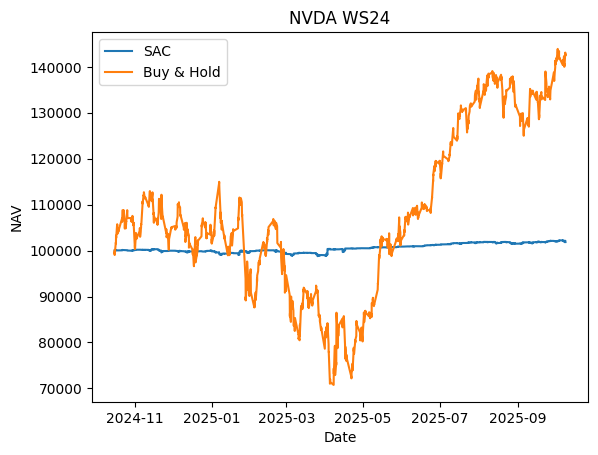

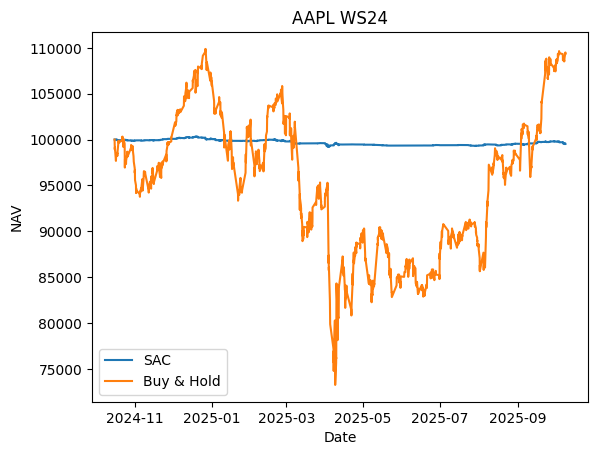

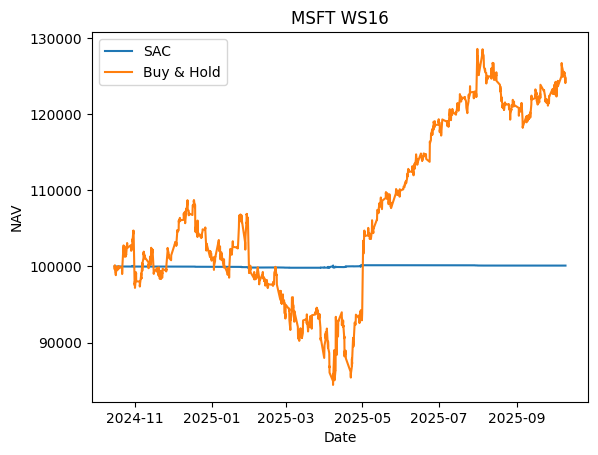

In [7]:
import pandas as pd, matplotlib.pyplot as plt, os

RESULTS_DIR = "/content/drive/MyDrive/Results_May_2025/results_sac_walkforward"
winners = [("NVDA",24), ("AAPL",24), ("MSFT",16)]

for sym, ws in winners:
    path = os.path.join(RESULTS_DIR, "signals", f"{sym}_ws{ws}_sac_signals.csv")
    s = pd.read_csv(path, parse_dates=["Datetime"])
    if "Close" not in s.columns:
        raise RuntimeError(f"'Close' not in {path}; re-run training to ensure signals CSV includes Close.")
    base = float(s["Portfolio"].iloc[0])
    bh = s["Close"] / s["Close"].iloc[0] * base
    plt.figure()
    plt.plot(s["Datetime"], s["Portfolio"], label="SAC")
    plt.plot(s["Datetime"], bh, label="Buy & Hold")
    plt.title(f"{sym} WS{ws}")
    plt.legend(); plt.xlabel("Date"); plt.ylabel("NAV")
    plt.show()
